<div class="alert alert-block alert-success">

**Kakava et al scLepr hypothalamus paper figures**

</div>

<div class="alert alert-warning">

**What this notebook does**
    
This notebook reproduces the figures of the analysis the tdtomato sorted Lepr+ cells from the hypothalamus by Kakava at al

</div>  

<div class="alert alert-block alert-info">

**Where does the data come from?**
    
The shaping, preprocessing and the analysis of the single cell data is provided in seperate files. Here, h5ad files containing this information is loaded and used to reproduce the figures in the manuscript. The raw data including the fastq files and count tables can be downloaded the data from GEO (GSE65970, will soon be publicly avaialable). 
   
We provide the raw count table that can be used to regenerate all the figures of hte manuscipt here on Guthub. Following the notebooks, you can preprocess the data to generate the anndata objects, saved as h5ad files, that are used for this study under the '../rawdata' folder. These files are too large to load

Pyscenic analysis are performed on the high performance cluster of hte Utrecht Bioinformatics center


</div>  

<div class="alert alert-block alert-info">

**Notes**
    
The downsampled dataset is used for the majority of the analysis, except for calling the active gene regulatory networks. This dataset is normalised, but not regressed for nCounts

'tomcells' refer to the whole dataset, where only tdToamto+ sorted cells are used. Neurons are subsetted using 'neuronal cluster' information based on Tubb3 and Mapt expression. Nonneuronal cells are analysed seperately.

Note that the cell type names are slightly different. 'Chrh' neurons are naes to 'Trh' neurons. Similarly, the order of endothelial cluster numbers are changed in the manuscript. These are minor changes, however, we will update to the latest version upon publication of the manuscript

</div>  

In [115]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
data = './'


scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.0


In [116]:
sc.settings.set_figure_params(dpi=80)

## upload the data
Upload the already analysed dataset

In [117]:
adata = sc.read('../rawdata/Lepr_hypothalamus_tomcells_analysis.h5ad')
adata_down = sc.read('../rawdata/Lepr_hypothalamus_tomcells_down_analysis_celltype.h5ad')

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [118]:
adata_down

AnnData object with n_obs × n_vars = 824 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types', 'cell_types_condition'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variabl

## some generic stats
Here, we provide some of the statistics used in the manuscript

### Some statistics for cell numbers:

In [119]:
for cell_type in adata_down.obs['cell_types'].unique():
    print(cell_type,": ",len(adata_down[adata_down.obs['cell_types'].isin([cell_type])].obs_names))

Pomc_neurons :  46
oligodendrocytes :  4
Astrocytes :  21
Ghrh_neurons :  12
Tanycytes_1 :  44
Agrp_neurons_2 :  76
Crhr2_Npw_neurons :  53
Tanycytes_2 :  40
Agrp_neurons_3 :  21
Tanycytes_3 :  39
Crhr2_Prlh_neurons :  41
Crhr2_Crh_neurons :  38
Agrp_neurons_1 :  86
endothelial_3 :  35
Vlmcs_Igf2_Igf1 :  27
Vlmcs_Igf2_Edn3 :  30
Tanycytes_4 :  33
endothelial_2 :  32
Pitituary :  40
endothelial_1 :  63
endothelial_4 :  20
Microglia :  6
Nrn1_non_neuronal :  3
Vlmcs_penk_Gnrh2 :  6
OPCs :  8


### The difference between the ERCC content of fed and fasted conditions of Agrp neurons

In [120]:
adata_fasted = adata[adata.obs['condition'] == 'fasted']
adata_fed =adata[adata.obs['condition'] == 'fed']

In [121]:
print('ERCC_genes fasted',adata_fasted[adata_fasted.obs['cell_categories'] == 'Agrp_neurons'].obs['ERCC_genes'].median())
print('ERCC_genes fed',adata_fed.obs[adata_fed.obs['cell_categories'] == 'Agrp_neurons']['ERCC_genes'].median())
print('n_counts fasted',adata_fasted[adata_fasted.obs['cell_categories'] == 'Agrp_neurons'].obs['n_counts'].median())
print('n_counts fed',adata_fed[adata_fed.obs['cell_categories'] == 'Agrp_neurons'].obs['n_counts'].median())


ERCC_genes fasted 0.085898444
ERCC_genes fed 0.09644633
n_counts fasted 63640.555
n_counts fed 29487.922


Trying to set attribute `.uns` of view, copying.


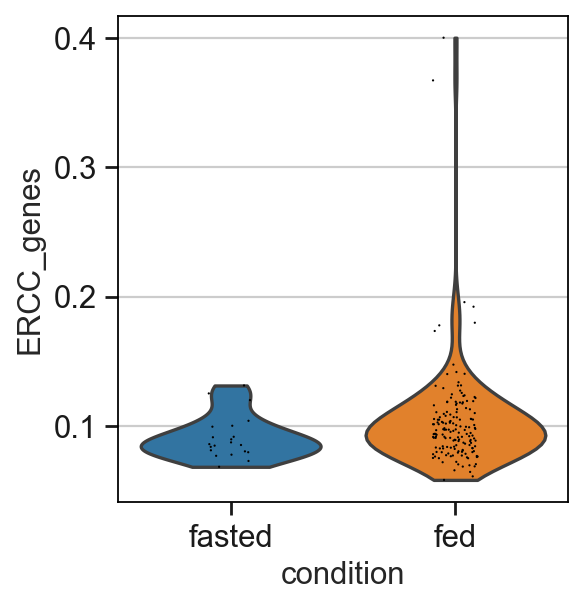

Trying to set attribute `.uns` of view, copying.


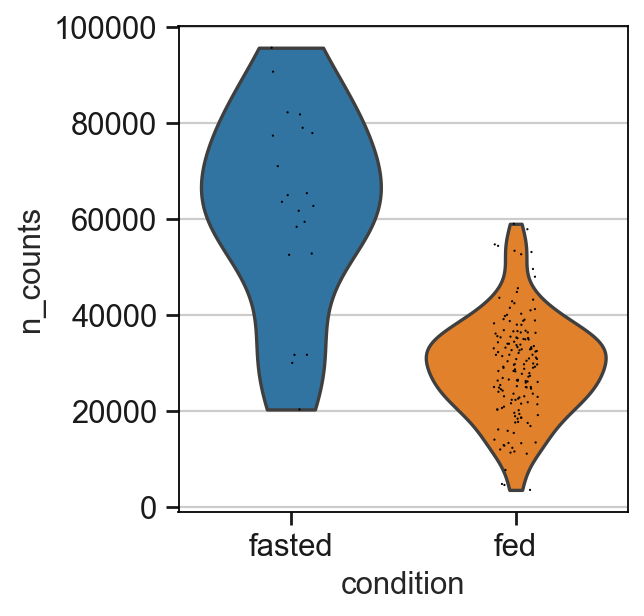

In [122]:
sc.pl.violin(adata[adata.obs['cell_categories'] == 'Agrp_neurons'], 
             keys = ['ERCC_genes'], groupby='condition')
sc.pl.violin(adata[adata.obs['cell_categories'] == 'Agrp_neurons'], 
             keys = ['n_counts'], groupby='condition')


### Distribution of n_counts, conditions and clusters in original and downsampled datasets

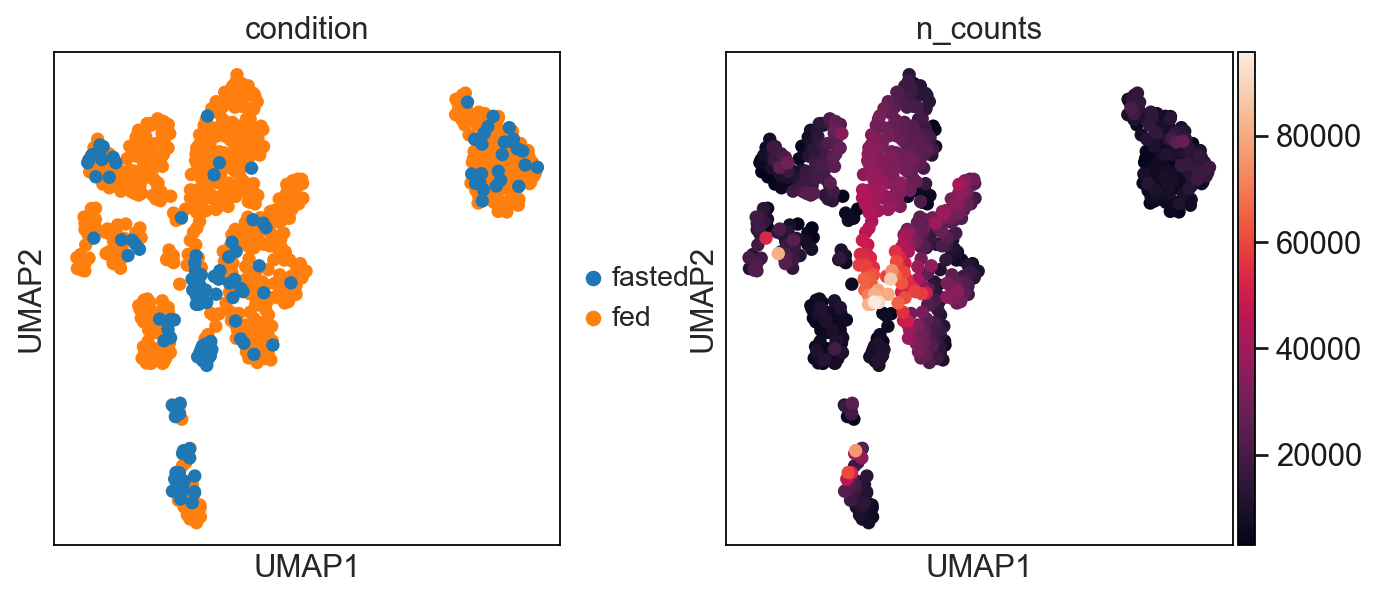

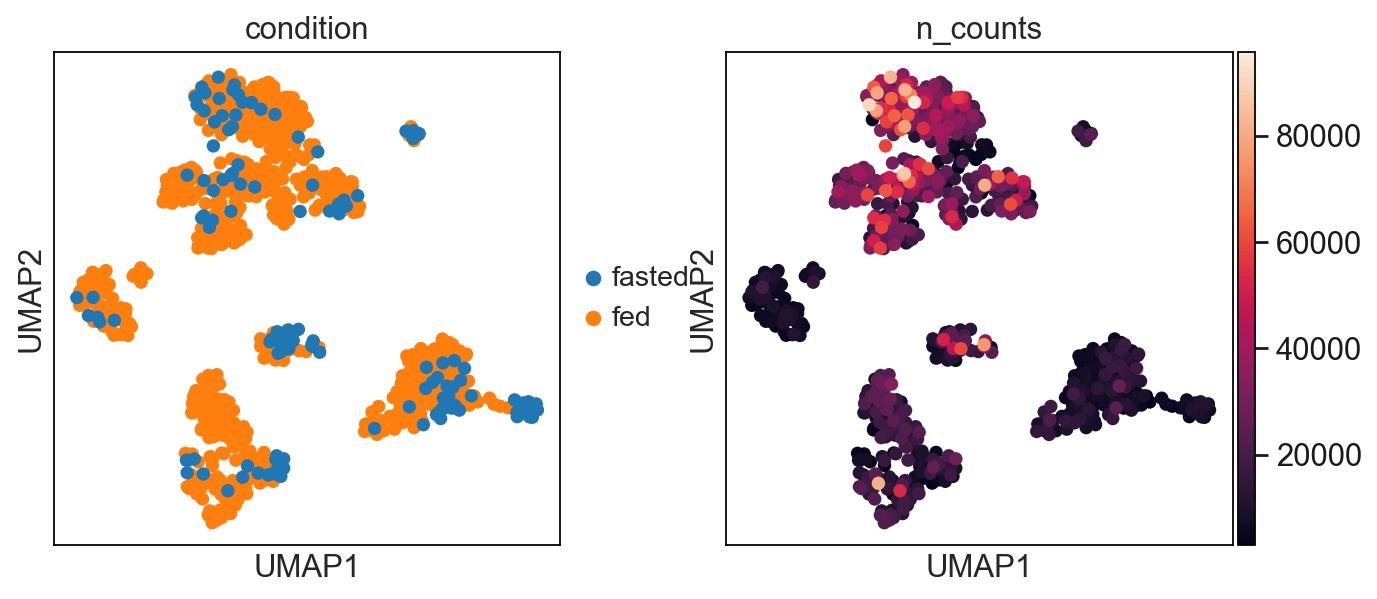

In [123]:
sc.pl.umap(adata, color=['condition','n_counts'], use_raw=True,save="_tomcells_condition_counts.pdf")
sc.pl.umap(adata_down, color=['condition','n_counts'], use_raw=True,save="_tomcells_condition_counts.pdf")


The distribution of clusters

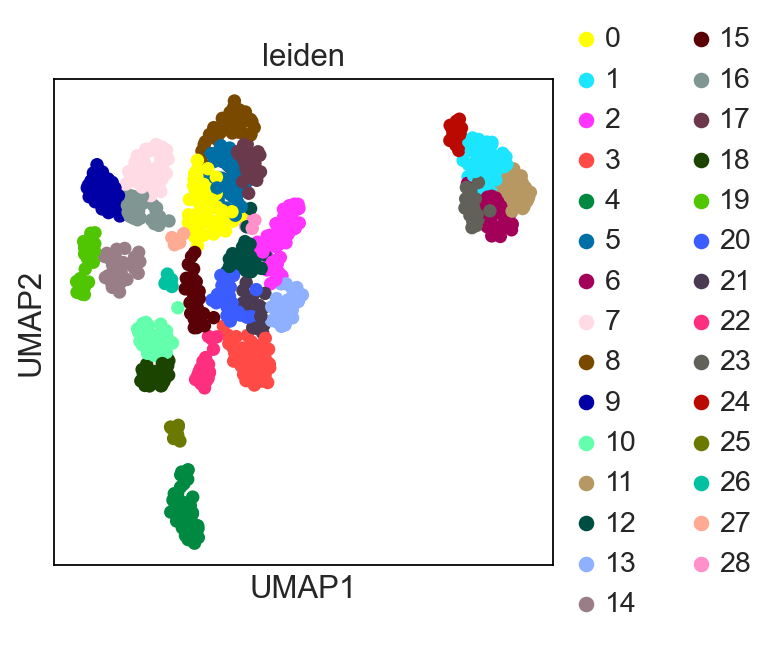

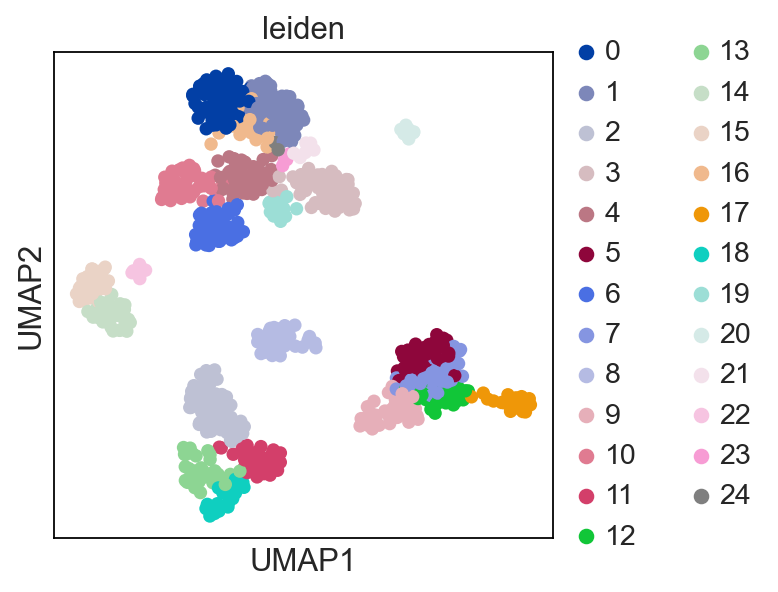

In [124]:
sc.pl.umap(adata, color=['leiden'], use_raw=True,save="_tomcells_leiden.pdf")
sc.pl.umap(adata_down, color=['leiden'], use_raw=True,save="_tomcells_down_leiden.pdf")

# Figure 1

## Fig. 1b : Cell types

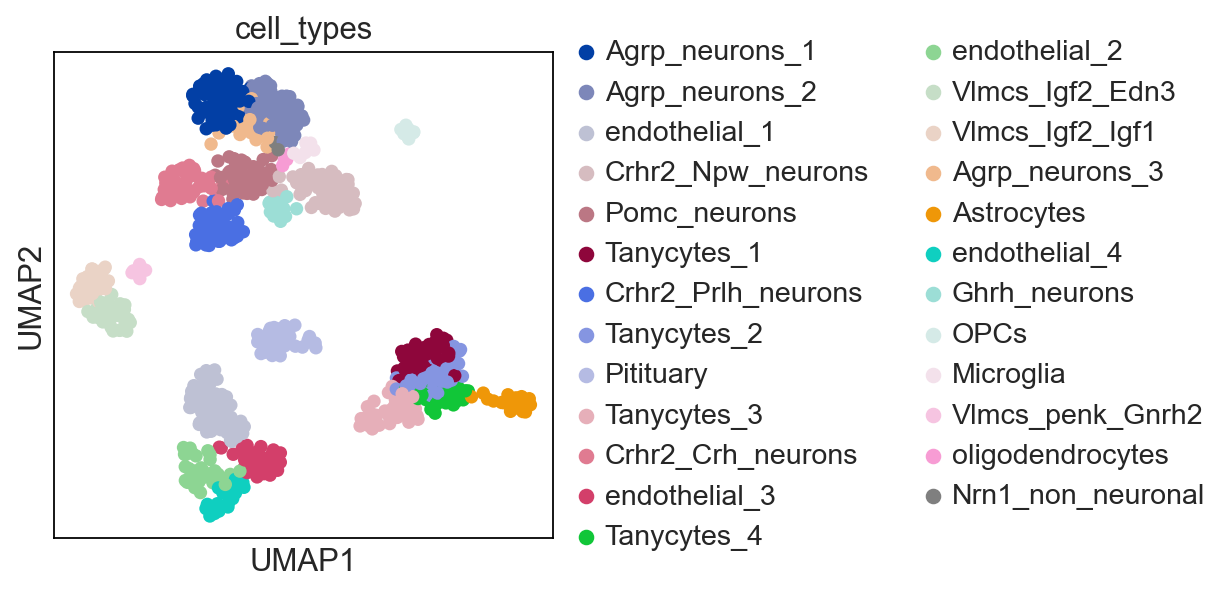

In [125]:
sc.pl.umap(adata_down, color=['cell_types'], use_raw=True,
           save="_tomcells_celltypes_Fig1b.pdf")


## Fig. 1c : Cell types violin plots

###### Violin plot showing selected lineage marker expression by Leiden clusters

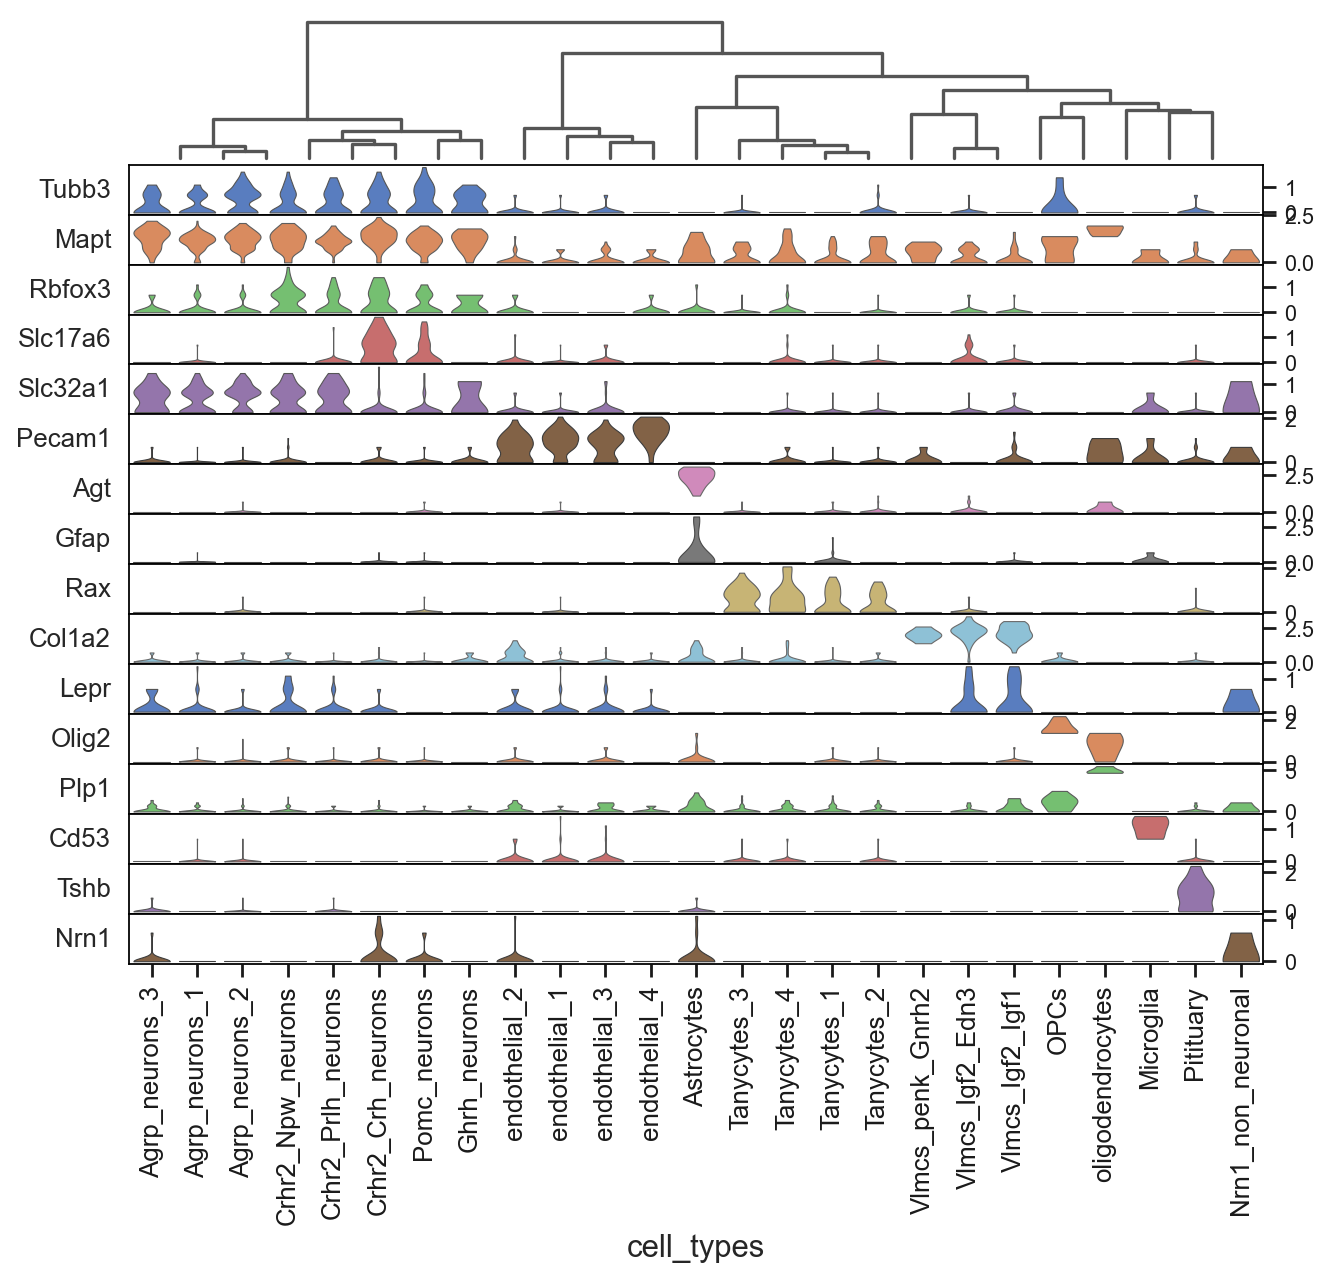

In [126]:
ax = sc.pl.stacked_violin(
    adata_down, ['Tubb3','Mapt','Rbfox3','Slc17a6','Slc32a1',
                 'Pecam1','Agt','Gfap','Rax','Col1a2','Lepr','Olig2','Plp1',
                'Cd53','Tshb','Nrn1'], groupby='cell_types', swap_axes=True, 
     var_group_labels=['Tubb3','Mapt'], dendrogram=True, 
    save='_tomcells_celltypes_Fig1c_corrected.pdf')

## Supp fig S1b
Batches and conditions used (Related to Figure 1)

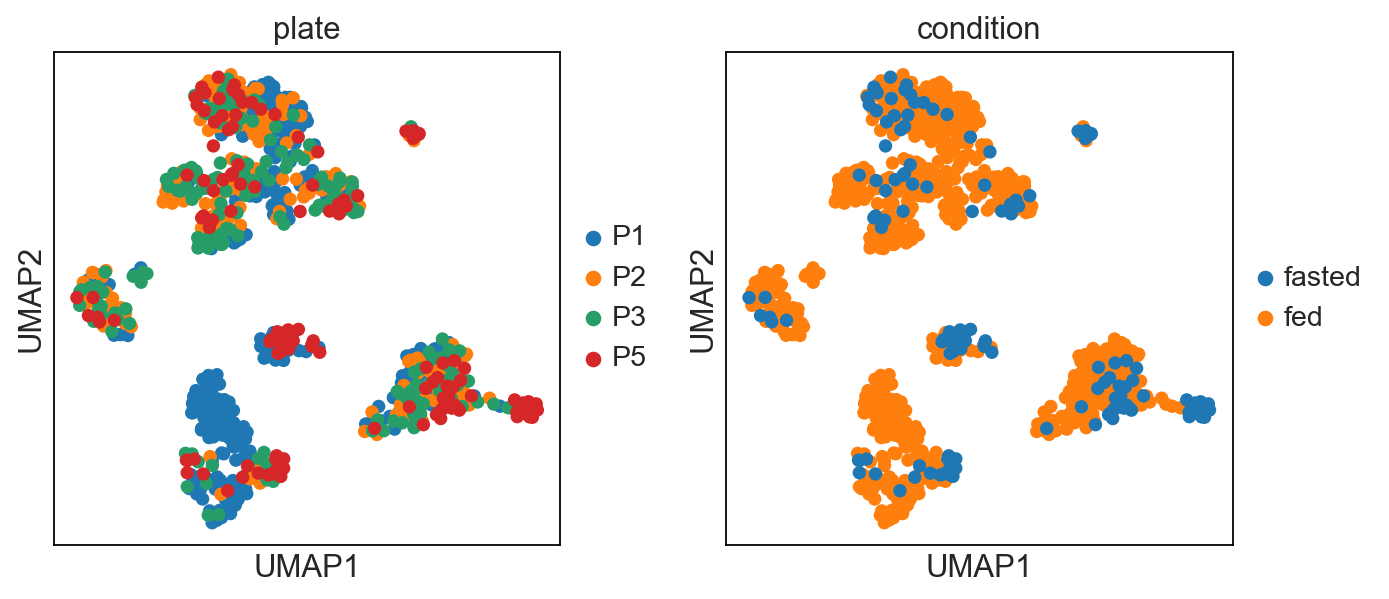

In [127]:
sc.pl.umap(adata_down, color=['plate', 'condition'], 
           use_raw=True,save="_batches_condition_FigS1b.pdf")

## Supp fig S1c
Quality control measures (Related to Figure 1)

In [128]:
adata

AnnData object with n_obs × n_vars = 824 × 3772
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'leiden', 'cell_types', 'cell_categories', 'cell_types_condition', 'cell_categories_condition'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'd

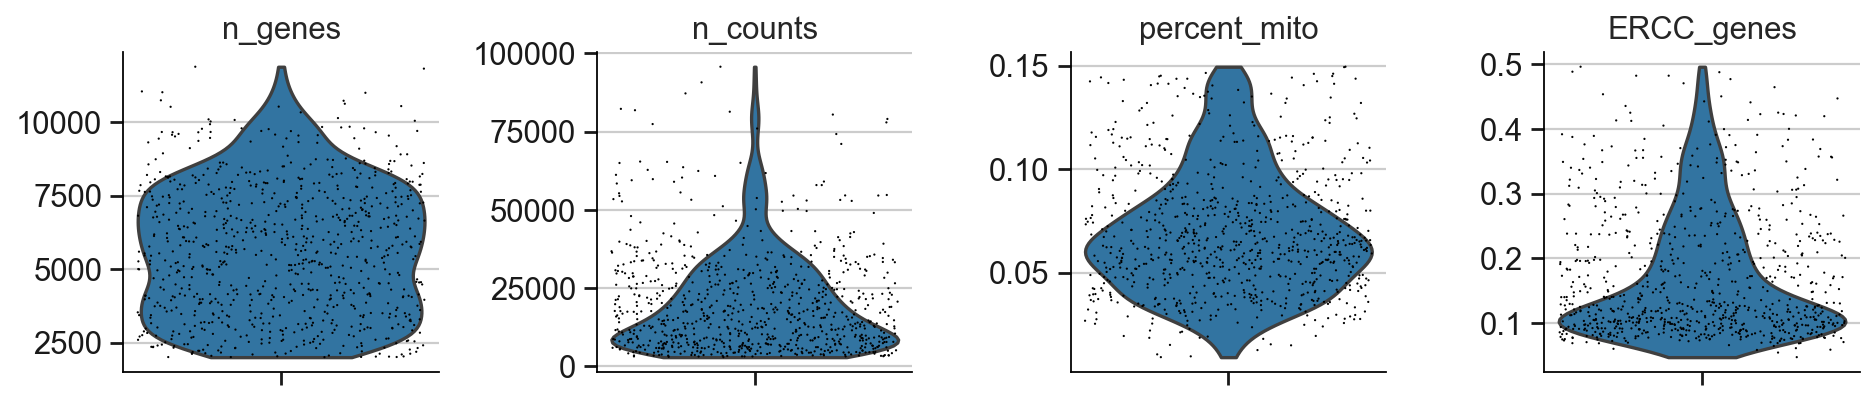

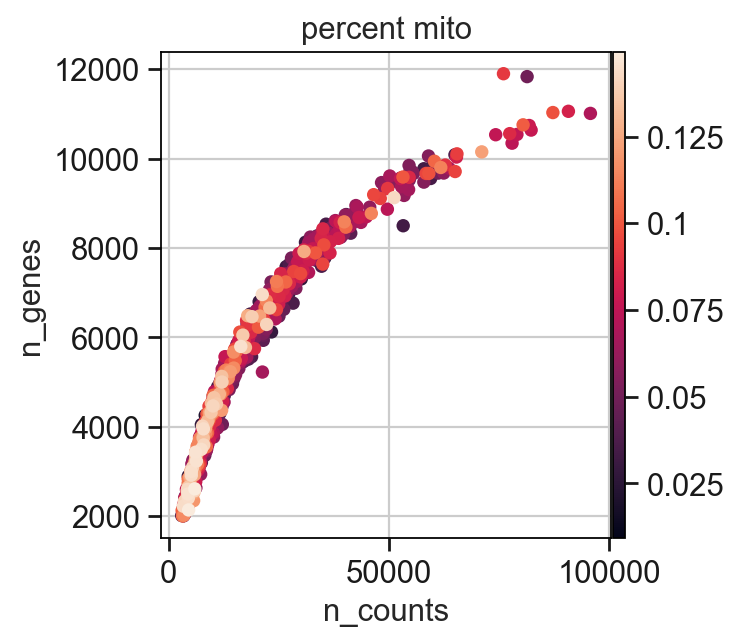

In [129]:
sc.pl.violin(adata_down, keys=['n_genes','n_counts','percent_mito','ERCC_genes'],
             jitter=0.4, multi_panel=True,save="_tomcells_qcmetrics_figS1c.pdf")
sc.pl.scatter(adata_down, x='n_counts', y='n_genes',color = 'percent_mito', 
              save= "_tomcells_complexity_figS1c.pdf")


## Supp fig 2a
Hierarchical clustering heatmap of cell types (Related to Figure 1)

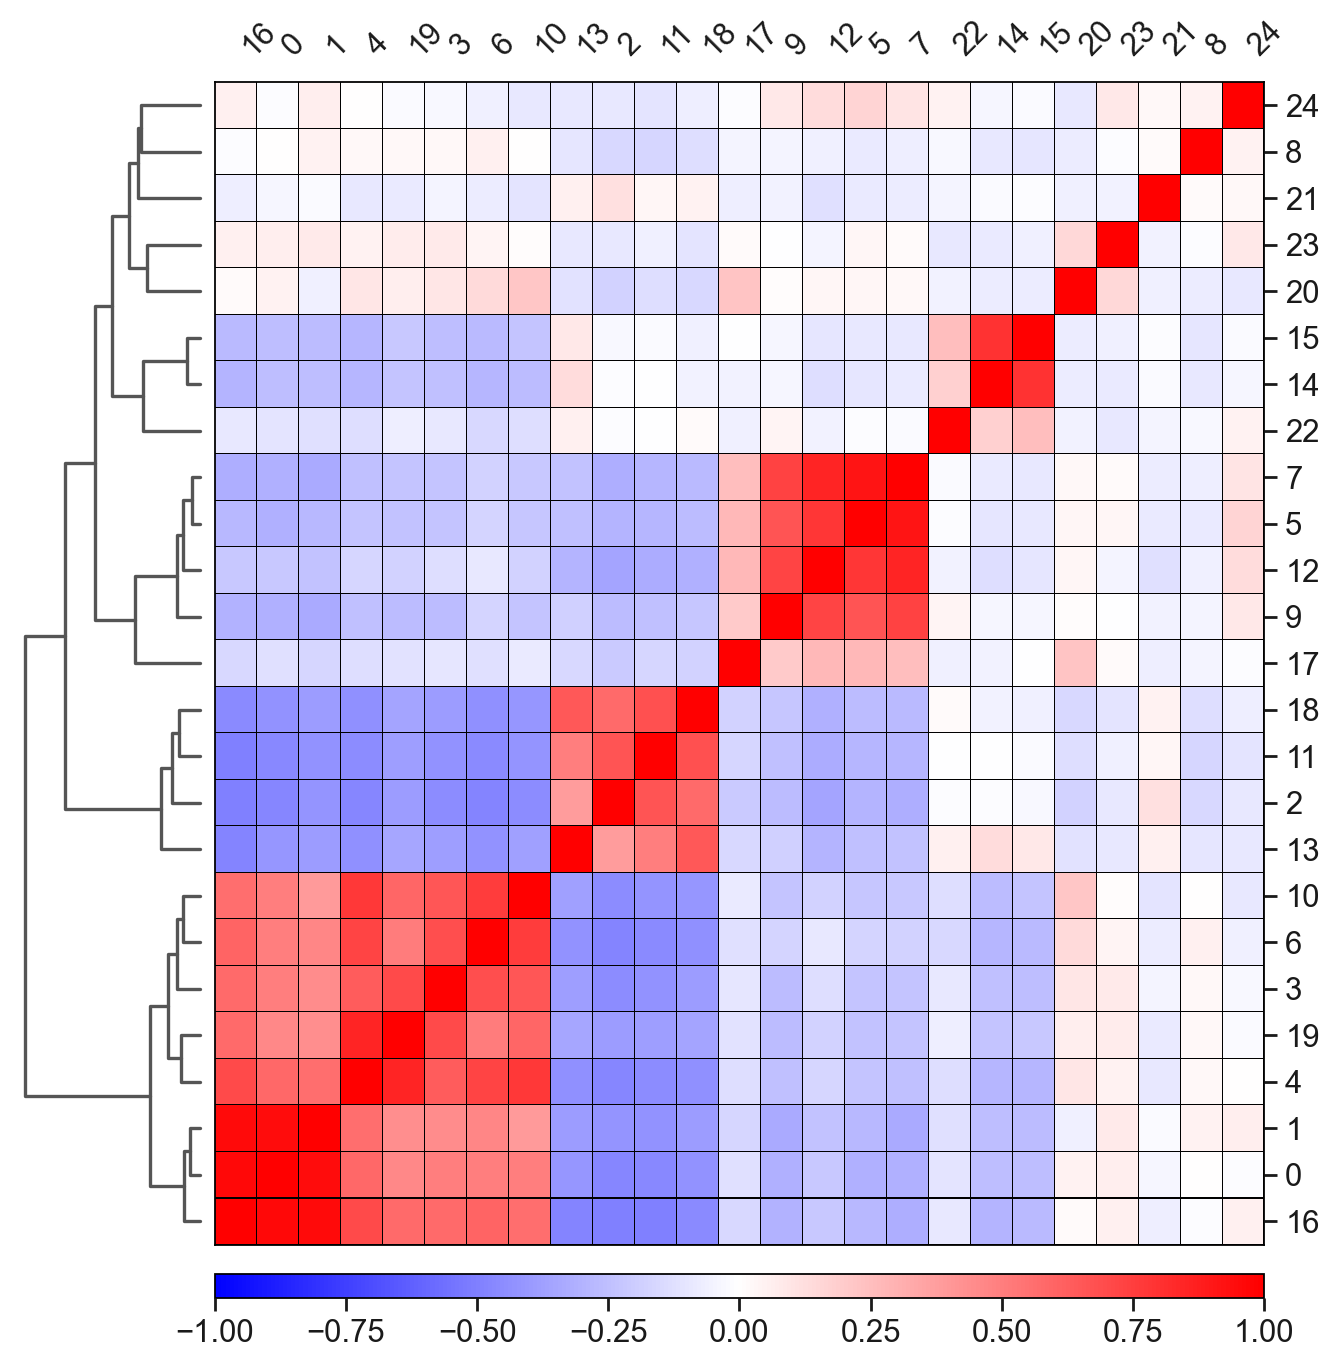

In [130]:
#Clustermap computed by sc.tl.dendogram
sc.pl.correlation_matrix(adata_down,groupby='leiden',figsize=[10,10],dendrogram ='dendogram_leiden',
                        save='_tomcells_down_dendogram_leiden_figS2a.pdf')

## Supp fig 2b
Lepr expression (Related to Figure 1)

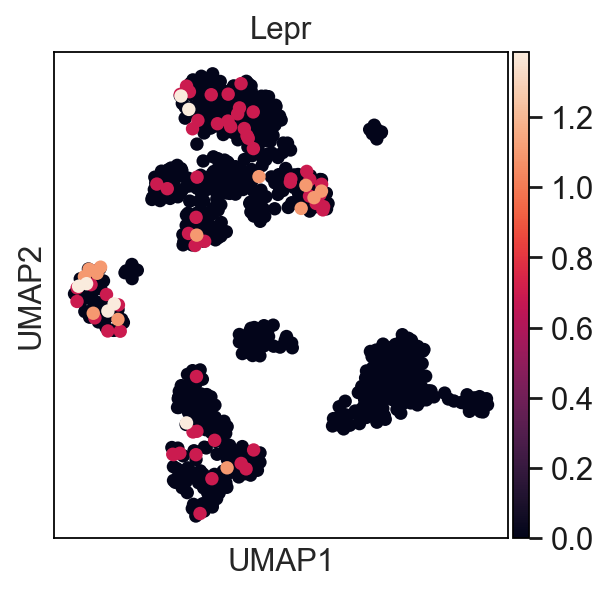

In [131]:
sc.pl.umap(adata_down, color=['Lepr'], use_raw=True,save="_tomcells_sup_Lepr.pdf")

# Figure 2

Upload the data of neuronal and nonneuronal populations

In [132]:
adata_down_neuron = sc.read('../rawdata/Lepr_hypothalamus_tomcells_analysis_neuron.h5ad')
adata_down_nonneuron = sc.read('../rawdata/Lepr_hypothalamus_tomcells_down_analysis_nonneuron.h5ad')

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [133]:
adata_down_neuron

AnnData object with n_obs × n_vars = 373 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersion

In [134]:
adata_down_nonneuron # Excludes pitutiary

AnnData object with n_obs × n_vars = 411 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersion

## Fig. 2a
Neuronal cell types displayed on UMAP

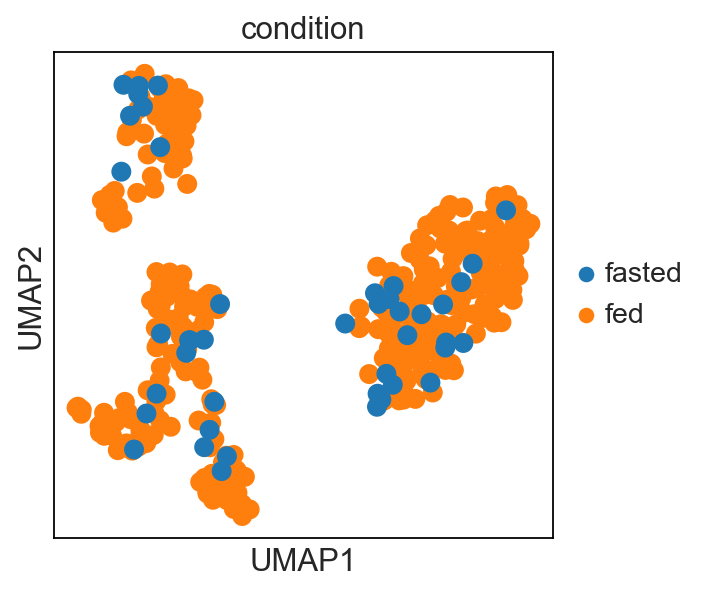

In [135]:
sc.pl.umap(adata_down_neuron, color=['condition'])

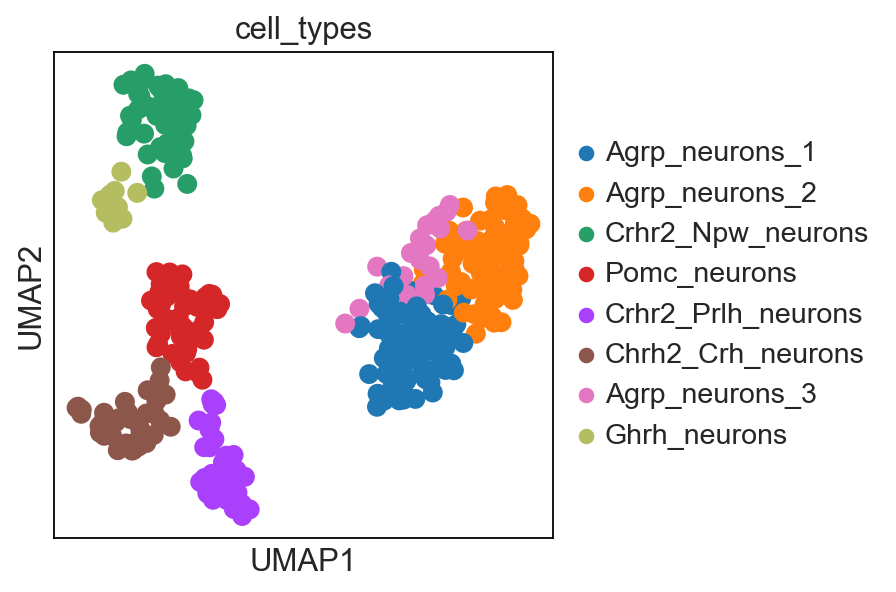

In [136]:
sc.pl.umap(adata_down_neuron, color=['cell_types']
           , use_raw=True,save="_tomcells_neuron_celltypes_fig2a.pdf")

## Fig. 2b
Neuronal marker gene expression by neuronal cell types

In [137]:
list_neuronal = ['Slc32a1', 'Slc17a6','Agrp', 'Npy', 'Pomc', 'Cartpt', 'Kiss1', 'Pdyn', 
 'Tac2','Ghrh', 'Gal', 'Trh', 'Th', 'Htr2c', 'Esr1', 'Ghr', 'Crhr1', 'Irs4', 
 'Ghsr', 'Egr1', 'Sst', 'Prlr', 'Pgr', 'Gfra1', 'Reln']
list_neuronal= np.intersect1d(list_neuronal,adata_down_neuron.raw.var_names)
list_neuronal

array(['Agrp', 'Cartpt', 'Crhr1', 'Egr1', 'Esr1', 'Gal', 'Gfra1', 'Ghr',
       'Ghrh', 'Ghsr', 'Htr2c', 'Irs4', 'Kiss1', 'Npy', 'Pdyn', 'Pgr',
       'Pomc', 'Prlr', 'Reln', 'Slc17a6', 'Slc32a1', 'Sst', 'Tac2', 'Th',
       'Trh'], dtype=object)

Stacked violin plots. Markers are displayed alphabetically; 'Slc32a1' and 'Slc17a6' manually moved to the top using the Adobe Illustrator

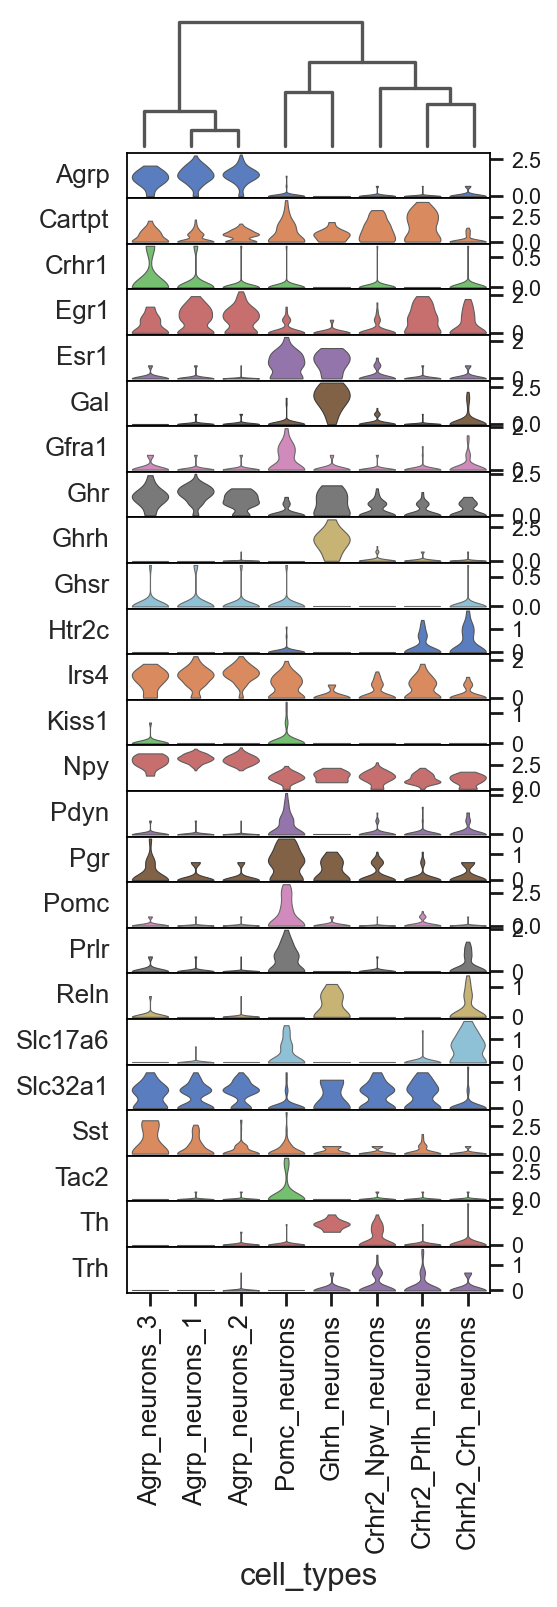

In [138]:
ax = sc.pl.stacked_violin(
    adata_down_neuron, list_neuronal, groupby='cell_types', swap_axes=True, 
     var_group_labels=['0'], dendrogram=True, 
    save='_neuronal_down_Fig2b_list_neuronal_genes_corrected.pdf')

## Fig. 2c

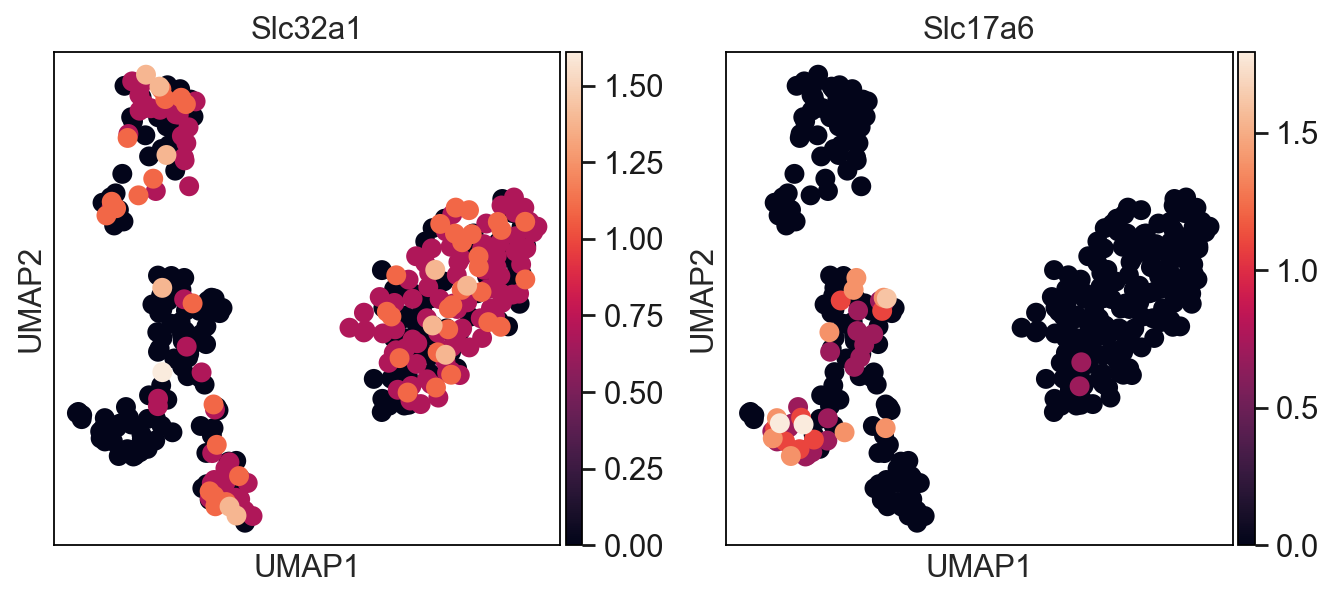

In [139]:
sc.pl.umap(adata_down_neuron, color=['Slc32a1', 'Slc17a6'], 
           use_raw=True,save="_neurons_Fig2c.pdf")

## Fig. 2d

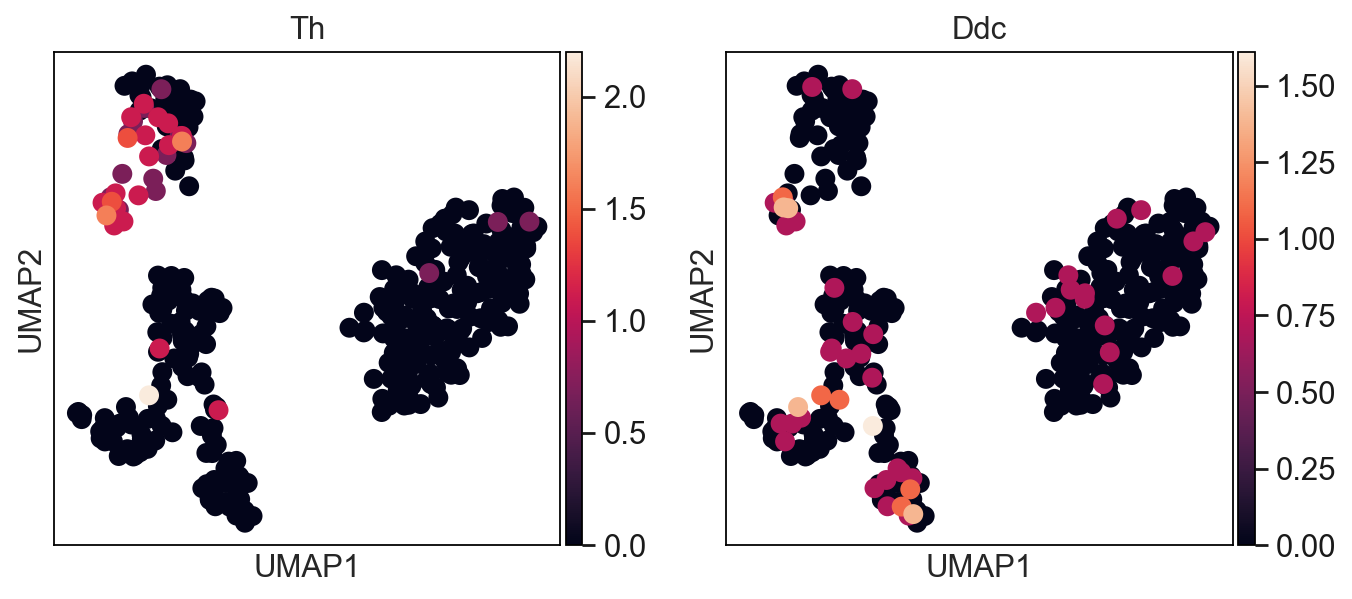

In [140]:
sc.pl.umap(adata_down_neuron, color=['Th', 'Ddc'], 
           use_raw=True,save="_neurons_Fig2d.pdf")

## Fig. 2e

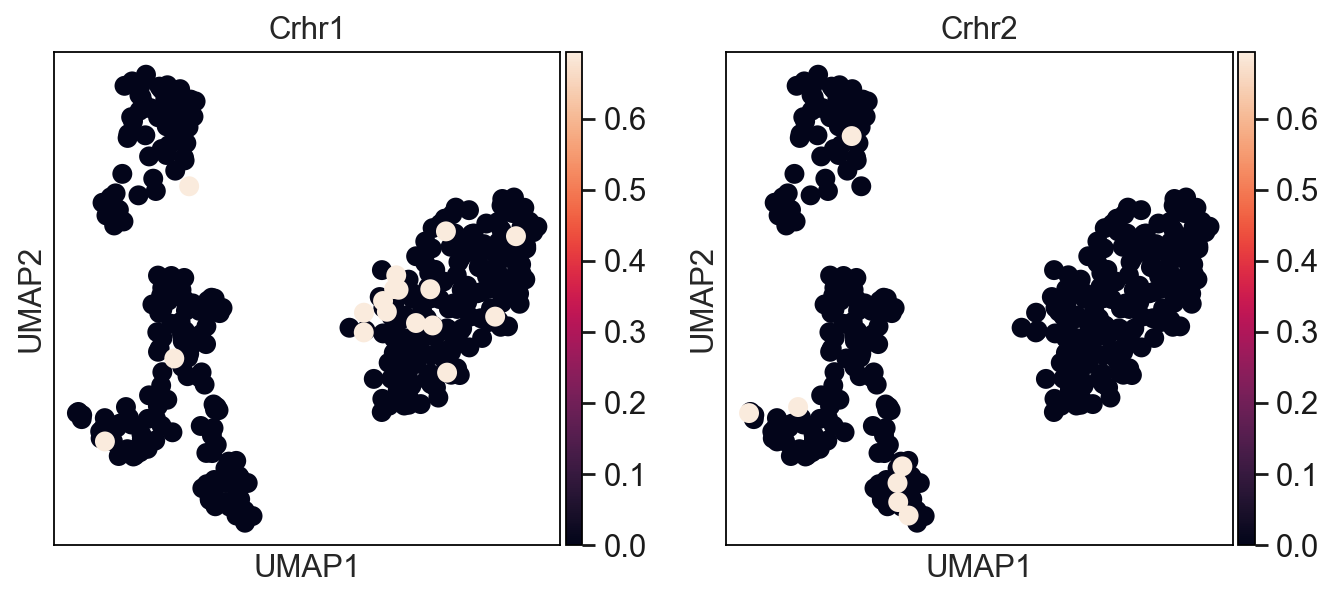

In [141]:
sc.pl.umap(adata_down_neuron, color=['Crhr1', 'Crhr2'], 
           use_raw=True,save="_neurons_Fig2e.pdf")

## Fig. 2f

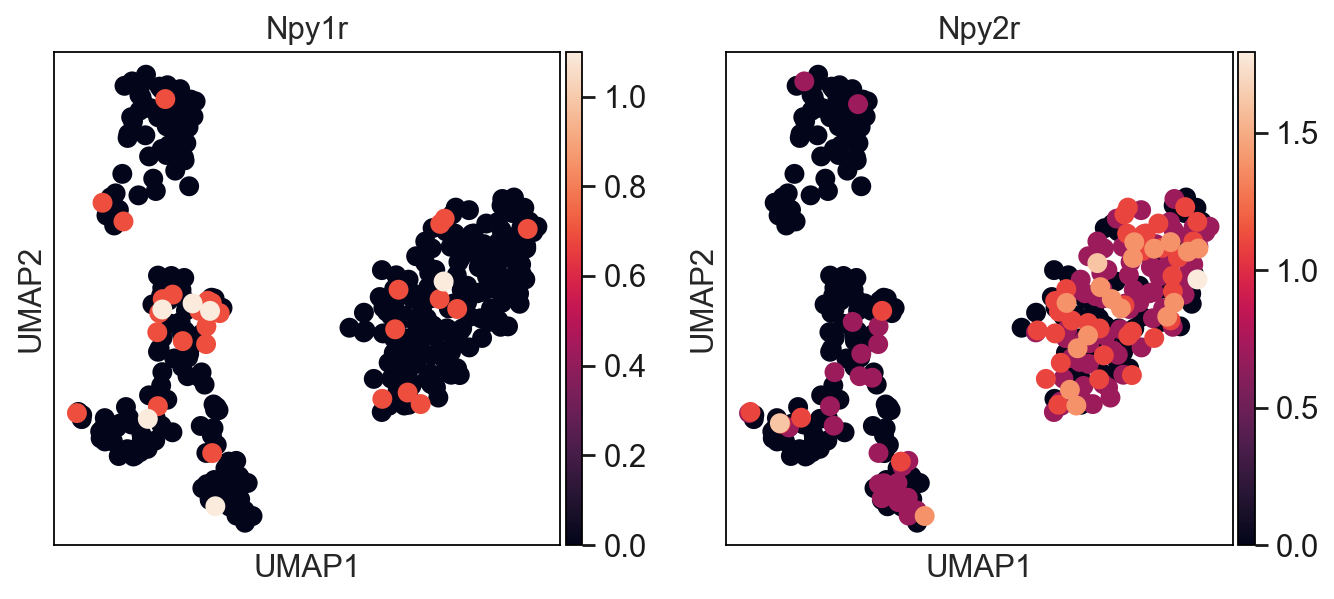

In [142]:
sc.pl.umap(adata_down_neuron, color=['Npy1r', 'Npy2r'], 
           use_raw=True,save="_neurons_Fig2f.pdf")

## Supp Fig. S3a
Neuropeptide expression by Lepr+ neurons (related to fig 2)

In [143]:
genes = ['Adcyap1','Adm','Agrp','Apln','Avp','Calca','Cartpt','Cbln1',
'Cbln2','Cbln3','Cbln4','Cck','Chga','Chgb','Cort','Crh',
'Dbi','Edn1','Edn2','Edn3','Gal','Galp','Gast','Ghrh',
'Gnrh1','Grp','Hcrt','Igf1','Igf2','Insl6','Kiss1','Nms',
'Nmu','Npvf','Npy','Nts','Oxt','Oxt','Pdyn','Penk',
'Pmch','Pnoc','Pomc','Prlh','Prok2','Pthlh','Retn','Rln1',
'Tac1','Tac2','Trh','Uts2','Vgf','Vip']
genes= np.intersect1d(genes,adata_down_neuron.raw.var_names)
genes

array(['Adcyap1', 'Adm', 'Agrp', 'Apln', 'Avp', 'Calca', 'Cartpt',
       'Cbln1', 'Cbln2', 'Cbln3', 'Cbln4', 'Cck', 'Chga', 'Chgb', 'Cort',
       'Crh', 'Dbi', 'Edn1', 'Edn2', 'Edn3', 'Gal', 'Galp', 'Gast',
       'Ghrh', 'Gnrh1', 'Grp', 'Hcrt', 'Igf1', 'Igf2', 'Insl6', 'Kiss1',
       'Nms', 'Nmu', 'Npy', 'Nts', 'Oxt', 'Pdyn', 'Penk', 'Pmch', 'Pnoc',
       'Pomc', 'Prlh', 'Prok2', 'Pthlh', 'Retn', 'Rln1', 'Tac1', 'Tac2',
       'Trh', 'Uts2', 'Vgf', 'Vip'], dtype=object)

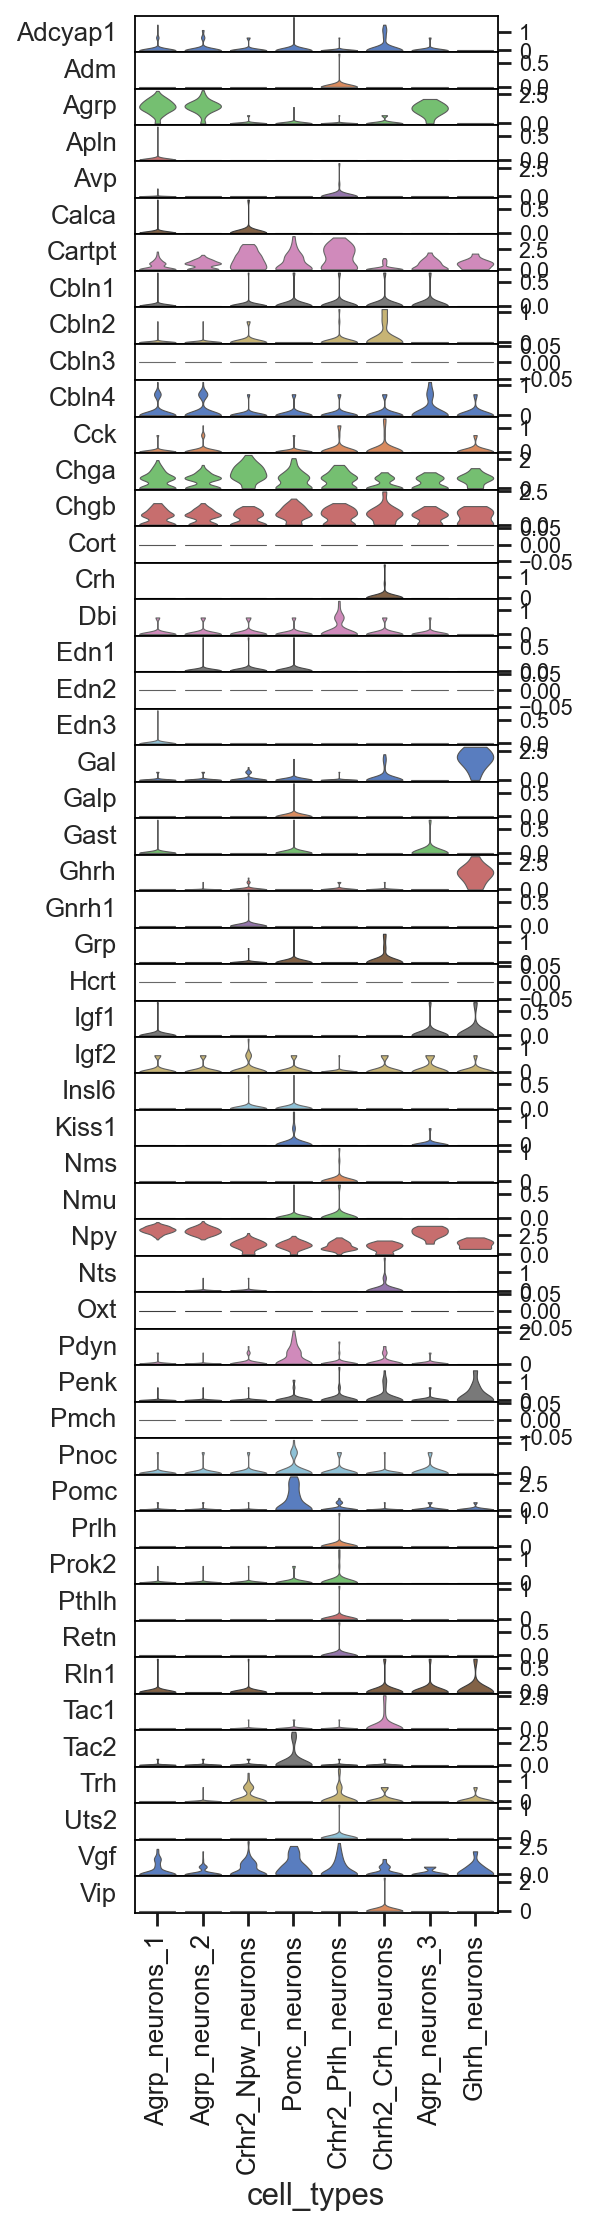

In [144]:
ax = sc.pl.stacked_violin(
    adata_down_neuron, genes, groupby='cell_types', swap_axes=True, 
      dendrogram=False,
        save='_neurons_FigS3a_neuropeptides.pdf')

## Supp Fig. S3b 
Neuropeptide receptor expression by Lepr+ neurons (related to fig 2)

In [145]:
receptors = ['Adcyap1r1','Avpr1a','Avpr1b','Avpr2','Cckar','Cckbr','Crhr1','Crhr2','Esr1','Esr2',
'Galr1','Galr2','Galr3','Ghr','Ghsr','Gnrhr','Grpr','Irs4','Kiss1r','Lepr',
'Mc3r','Mc4r','Mchr1','Npffr1','Npy1r','Npy2r','Npy5r','Ntsr1','Ntsr2',
'Oprd1','Oprk1','Oprl1','Oprm1','Oxtr','Pgr','Prokr1','Prokr2','Rxfp1',
'Rxfp2','Rxfp3','Sstr1','Sstr2','Sstr3','Sstr4','Sstr5','Tacr1','Tacr2',
'Tacr3','Trhr','Vipr1','Vipr2']
receptors= np.intersect1d(receptors,adata_down_neuron.raw.var_names)
receptors

array(['Adcyap1r1', 'Avpr1a', 'Avpr1b', 'Cckar', 'Cckbr', 'Crhr1',
       'Crhr2', 'Esr1', 'Esr2', 'Galr1', 'Galr2', 'Galr3', 'Ghr', 'Ghsr',
       'Gnrhr', 'Grpr', 'Irs4', 'Kiss1r', 'Lepr', 'Mc3r', 'Mc4r', 'Mchr1',
       'Npffr1', 'Npy1r', 'Npy2r', 'Npy5r', 'Ntsr1', 'Ntsr2', 'Oprd1',
       'Oprk1', 'Oprl1', 'Oprm1', 'Oxtr', 'Pgr', 'Prokr1', 'Prokr2',
       'Rxfp1', 'Rxfp2', 'Rxfp3', 'Sstr1', 'Sstr2', 'Sstr3', 'Sstr5',
       'Tacr1', 'Tacr3', 'Trhr', 'Vipr1', 'Vipr2'], dtype=object)

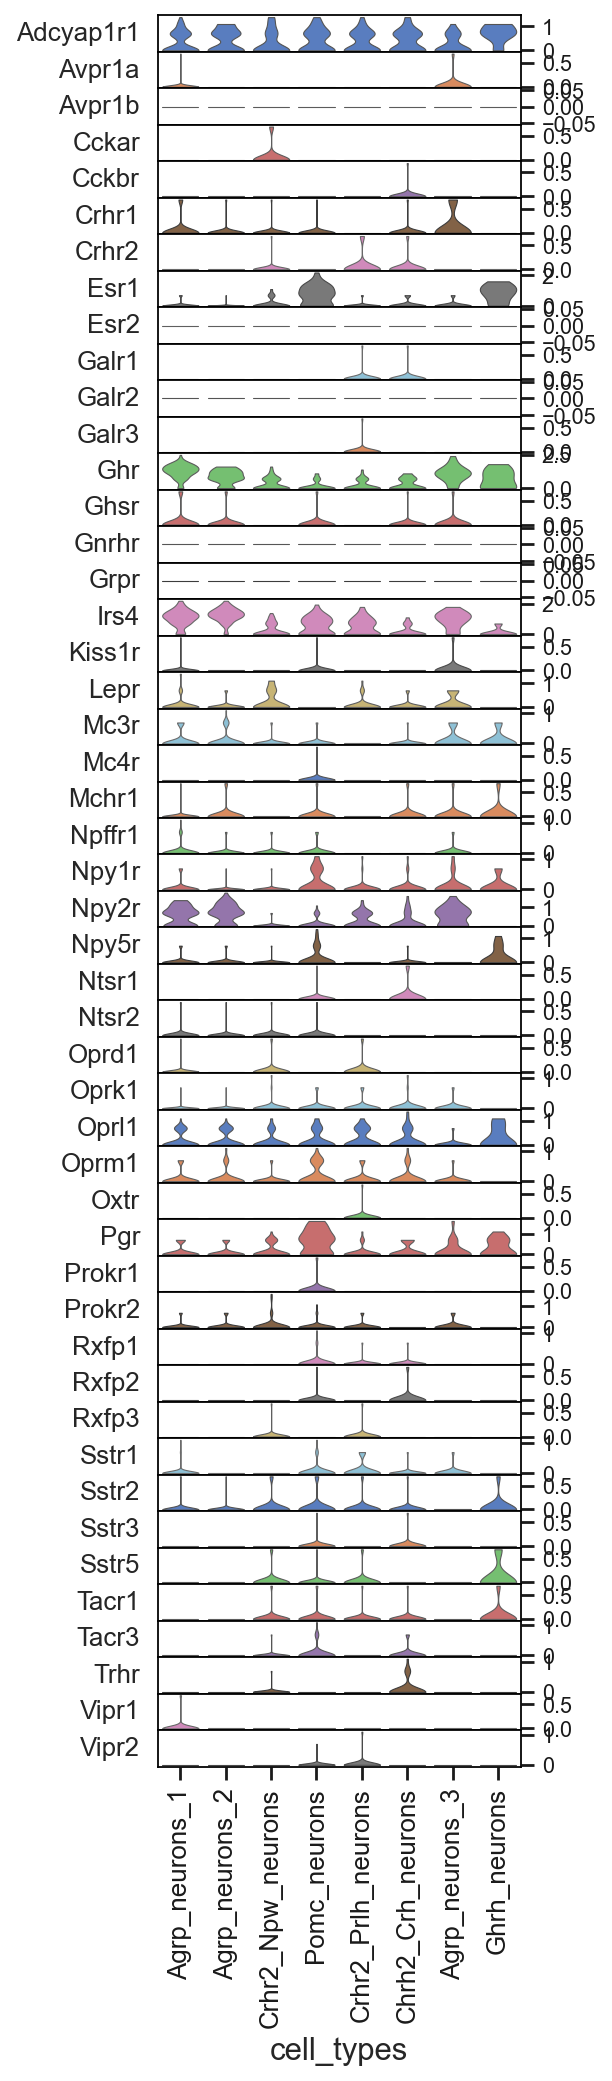

In [146]:
ax = sc.pl.stacked_violin(
    adata_down_neuron, receptors, groupby='cell_types', swap_axes=True, 
      dendrogram=False,
        save='_neurons_FigS3b_neuropeptides_receptors.pdf')

# Figure 3
Analysis of Trh neuronal clusters

In [147]:
adata_down_neuron.obs['cell_types']

tom_P1_fed_2              Pomc_neurons
tom_P1_fed_7              Ghrh_neurons
tom_P1_fed_9              Ghrh_neurons
tom_P1_fed_10           Agrp_neurons_2
tom_P1_fed_11           Agrp_neurons_2
                           ...        
tom_P5_fasted_222       Agrp_neurons_1
tom_P5_fasted_223       Agrp_neurons_1
tom_P5_fasted_229         Ghrh_neurons
tom_P5_fasted_232       Agrp_neurons_2
tom_P5_fasted_241    Chrh2_Crh_neurons
Name: cell_types, Length: 373, dtype: category
Categories (8, object): [Agrp_neurons_1, Agrp_neurons_2, Crhr2_Npw_neurons, Pomc_neurons, Crhr2_Prlh_neurons, Chrh2_Crh_neurons, Agrp_neurons_3, Ghrh_neurons]

Fetch Trh neurons

In [148]:
adata_down_trhneurons = adata_down_neuron[adata_down_neuron.
                            obs['cell_types'].isin(["Crhr2_Npw_neurons",
                                                    "Crhr2_Prlh_neurons","Chrh2_Crh_neurons"])].copy()
#.str.contains('Crhr2')] -> Correct misspelled 'Chrh2'


In [149]:
adata_down_trhneurons

AnnData object with n_obs × n_vars = 132 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersion

Recalculate the neighborhood, umap embedding

In [150]:
sc.pp.neighbors(adata_down_trhneurons, n_neighbors=15, n_pcs=40) #
sc.tl.umap(adata_down_trhneurons,spread = 1.5,maxiter =1000,min_dist=1.5)


## Fig. 3a
Marker gene expression on dotplots

Note that the Crhr2 clusters are renamed to Trh

In [151]:
Trh_genes = ['Trh', 'Lhx1', 'Lhx1os', 'Ptger3', 'Adra1b', 
             'Cxcl12', 'Cnr1', 'Tac1', 'Pirt', 'Crhr2','Prlr']

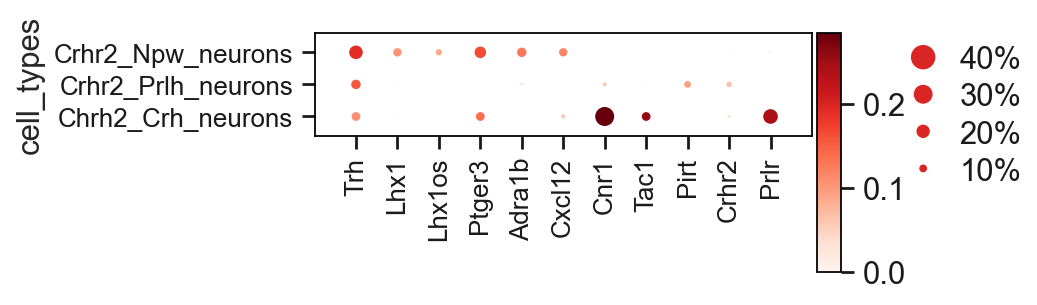

In [152]:
ax = sc.pl.dotplot(
    adata_down_trhneurons, Trh_genes, groupby='cell_types',
      dendrogram=False,figsize = [5,2],
        save='_trhneurons_Fig3a_left.pdf')

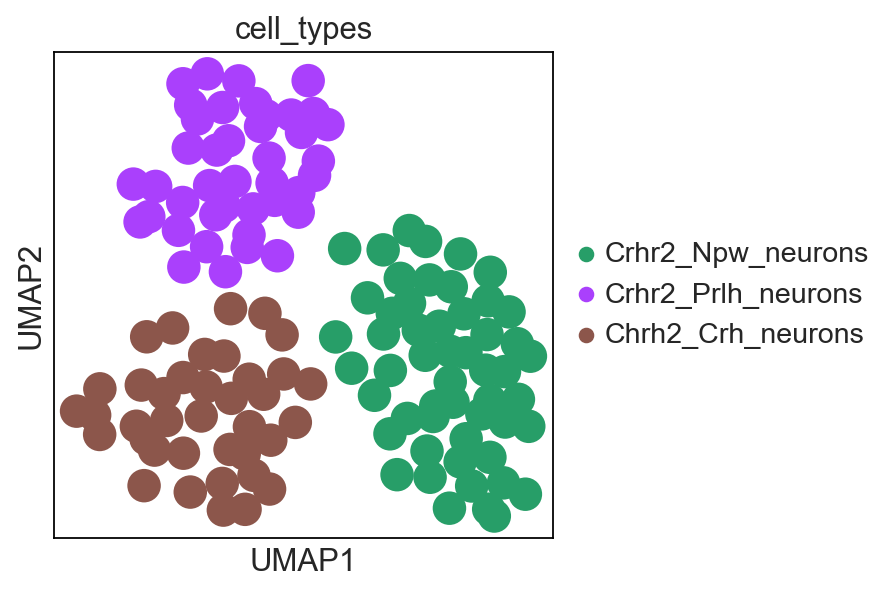

In [153]:
sc.pl.umap(adata_down_trhneurons, color=['cell_types'],
          use_raw=True,save="_trhneurons_Fig3a_right.pdf")
# The colors dont match the figure, but this is acceptable

## Fig. 3b

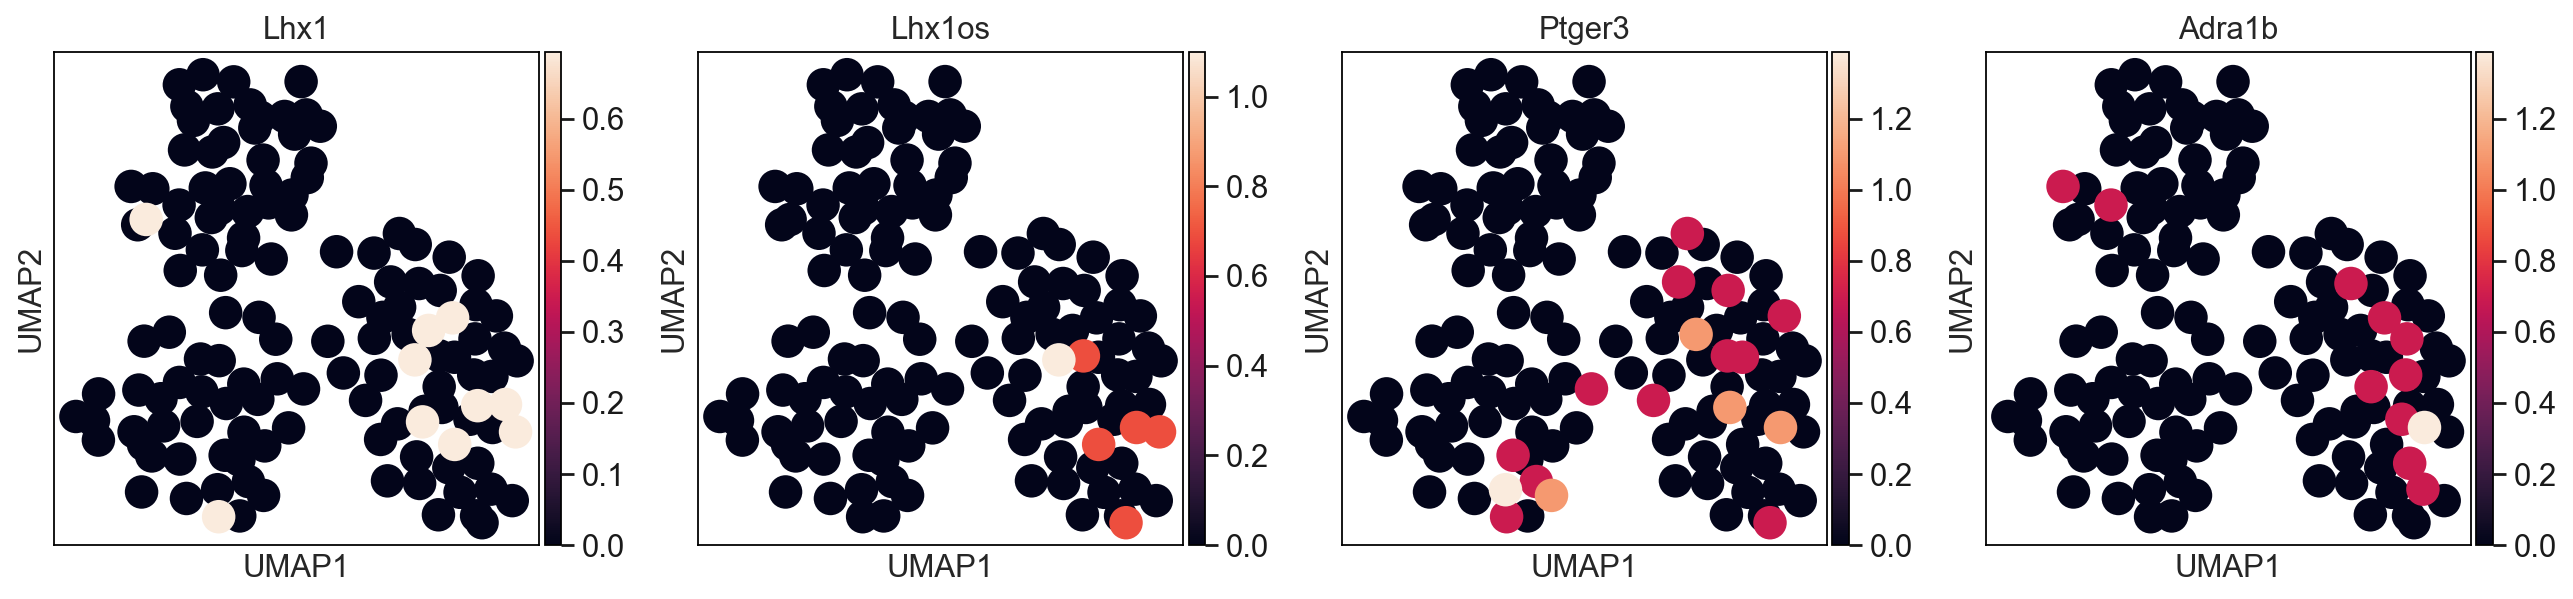

In [154]:
sc.pl.umap(adata_down_trhneurons, color=['Lhx1', 'Lhx1os', 'Ptger3', 'Adra1b' ],
          use_raw=True,save="_trhneurons_Fig3b.pdf")

## Fig. 3c

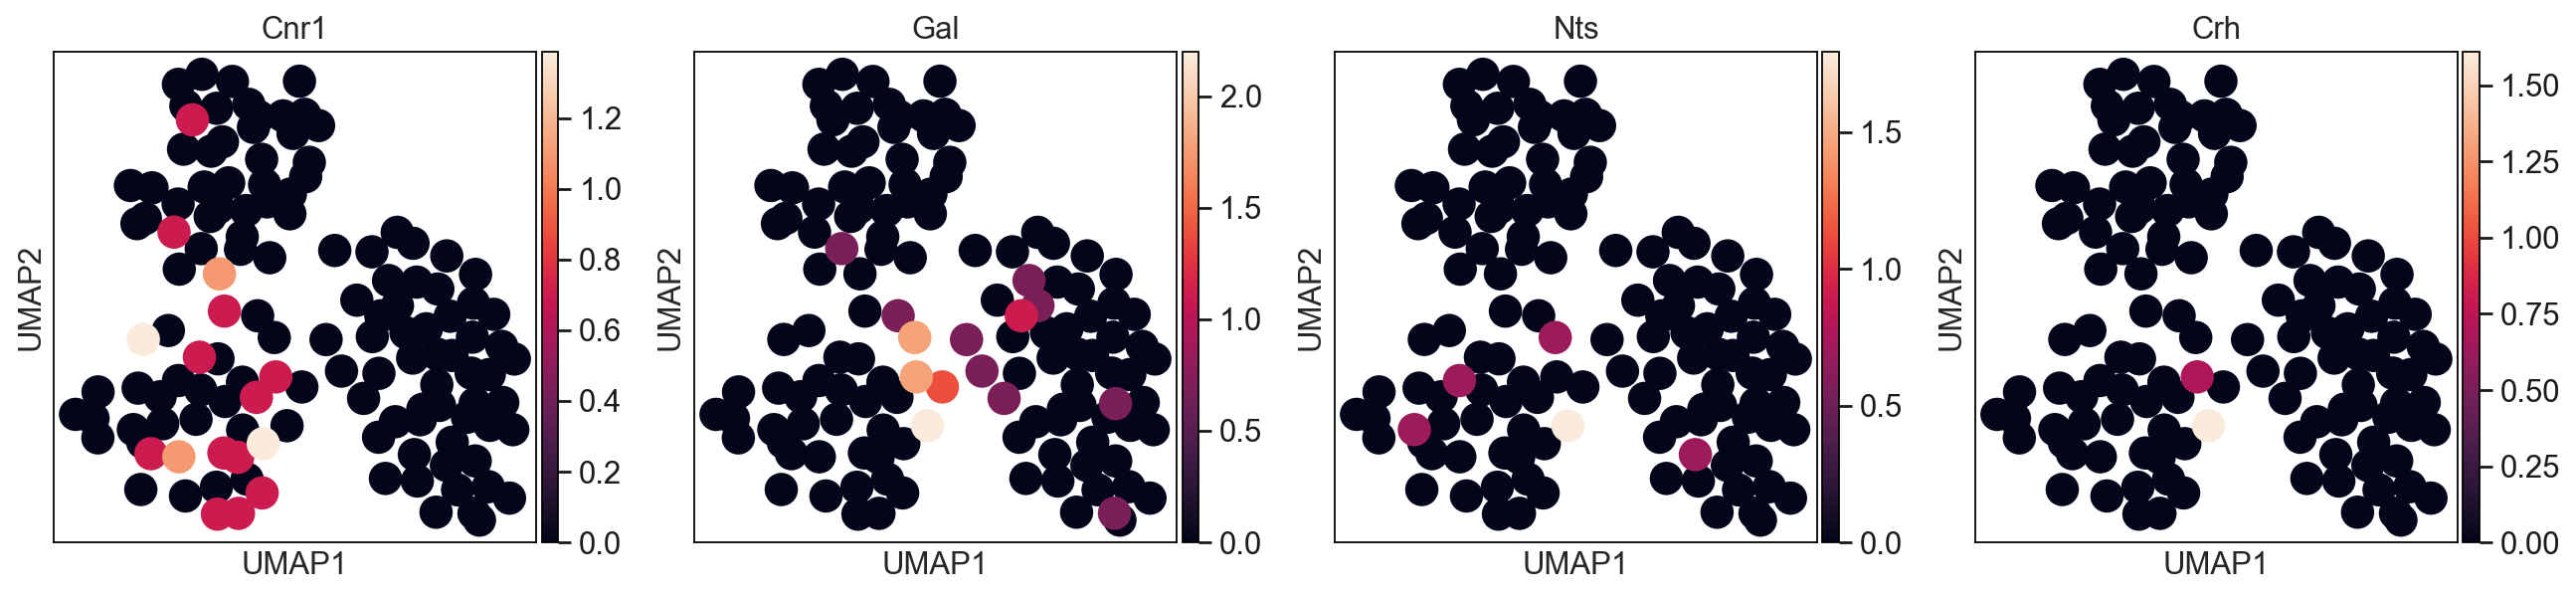

In [155]:
sc.pl.umap(adata_down_trhneurons, color=['Cnr1', 'Gal', 'Nts', 'Crh'],
          use_raw=True,save="_trhneurons_Fig3c.pdf")


# Figure 4
Nonneuronal cells

## Fig 4a

In [156]:
tanycytes = adata_down_nonneuron[adata_down_nonneuron.obs['cell_types'].str.contains('Tanycyte')]
tanycytes # 156 cells

View of AnnData object with n_obs × n_vars = 156 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'di

stacked violin plots of tanycyte markers

In [157]:
tanycyte_markers = ['Rax', 'Vim', 'Ppp1r1b', 'Nes', 'Gfap','Crym', 'Frzb', 'Col25a1', 'Adm', 
                    'Cacna2d2', 'Vcan', 'Cd59a', 'Slc17a8','Tll1', 'Lrp2','Cntfr']

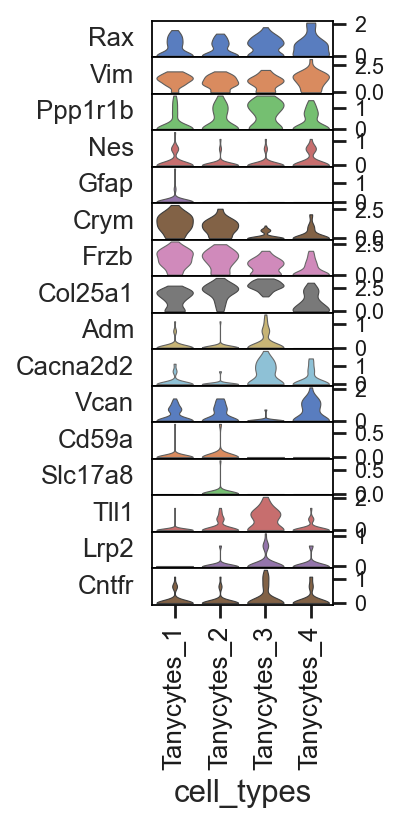

In [158]:
ax = sc.pl.stacked_violin(
    tanycytes, tanycyte_markers, groupby='cell_types', swap_axes=True, 
      dendrogram=False,
        save='_tanycytes_Fig4a.pdf')

## Fig 4b
Umaps of Tanycyte clusters with: Rax, Vim, Ppp1r1b, Nes, Gfap,Crym, Frzb, Col25a1, Adm, Cacna2d2, Vcan, Cd59a, Slc17a8,Tll1, Lrp2,Cntfr. 

In [159]:
endothelial = adata_down_nonneuron[adata_down_nonneuron.obs['cell_types'].str.contains('endothelial')]
endothelial # 150 cells

View of AnnData object with n_obs × n_vars = 150 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'di

dotplots of endothelial marker genes

In [160]:
genes = ['Pecam1', 'Ly6c1', 'Ly6a', 'Slco1c1','Slc38a5', 'Vwf', 'Slc16a1', 'Vegfc', 
         'Sema3g', 'Gkn3', 'Acta2', 'Myh11', 'Pdgfrb', 'Vtn']

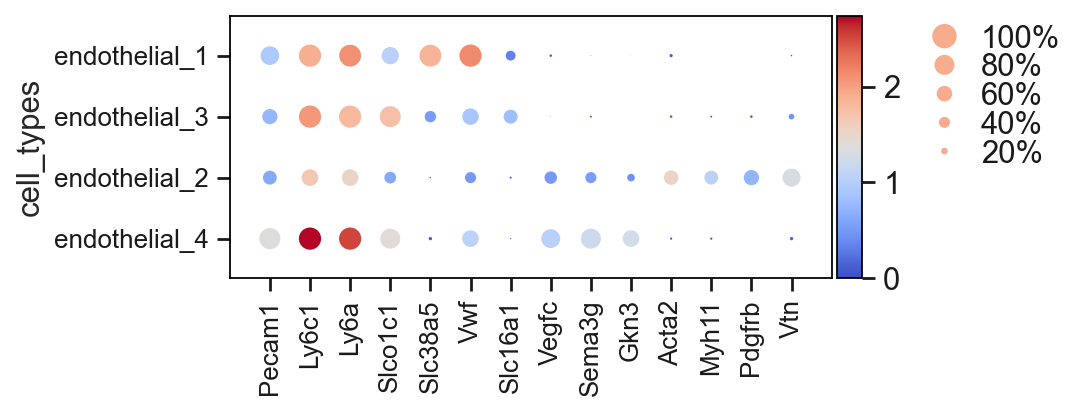

In [161]:
ax = sc.pl.dotplot(
    endothelial, genes, groupby='cell_types', dot_max=1, color_map = 'coolwarm', 
      dendrogram=False,
        save='_endothelial_Fig4b.pdf')


## Fig 4c: 
Violin plots of VLMC clusters with: Igf2, Gnrh1, Penk, Spp1


In [162]:
VLMC = adata_down_nonneuron[adata_down_nonneuron.obs['cell_types'].str.contains('Vlmc')]
VLMC # 63 cells

View of AnnData object with n_obs × n_vars = 63 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dis

stacked violin plots of VLMC marker genes

In [163]:
genes = ['Igf2', 'Gnrh1', 'Penk', 'Spp1']

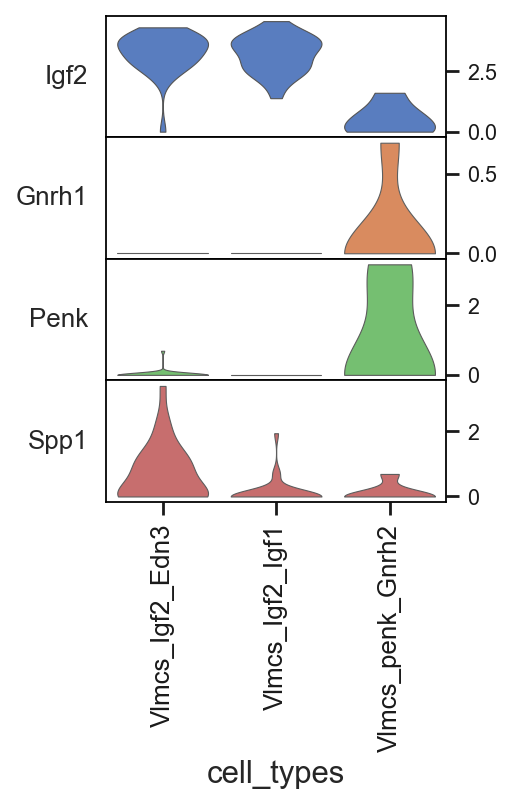

In [164]:
ax = sc.pl.stacked_violin(
    VLMC, genes, groupby='cell_types', swap_axes=True, 
      dendrogram=False,figsize= [3,4],
        save='_VLMC_Fig4c.pdf')

## Fig 4d 
Violin plots of glial (Oligo, OPC, Astro, MM) clusters marked with: Mobp, Ermn, Mbp, Fyn, Bmp4, Agt, Gfap, Itih3, Cx3cr1, Mrc1.


In [165]:
astroglial = adata_down_nonneuron[adata_down_nonneuron.obs['cell_types'].isin(['Microglia','OPCs',
                        'oligodendrocytes','Astrocytes'])] #eclude 'Nrn1_non_neuronal' unknown
astroglial # 39 cells


View of AnnData object with n_obs × n_vars = 39 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dis

stacked violin plots of glial markers

In [166]:
genes = ['Mobp', 'Ermn', 'Mbp', 'Fyn', 'Bmp4', 'Agt', 'Gfap', 'Itih3', 'Cx3cr1', 'Mrc1']

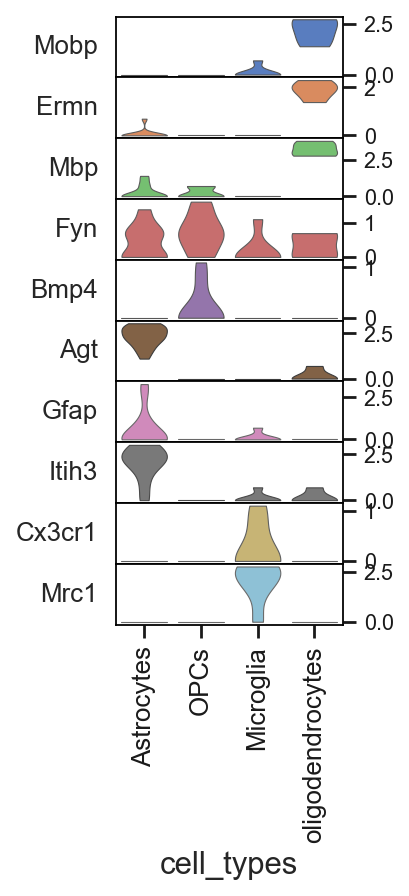

In [167]:
ax = sc.pl.stacked_violin(
    astroglial, genes, groupby='cell_types', swap_axes=True, 
      dendrogram=False,figsize=[2,5],
        save='_astroglial_Fig4d.pdf')

## Fig 4e
Umaps showing astrocytes only. Markers: Agt, Gfap, Itih3

In [168]:
astrocytes = adata_down_nonneuron[adata_down_nonneuron.obs['cell_types'].isin(['Astrocytes'])]
astrocytes # 21 cells


View of AnnData object with n_obs × n_vars = 21 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dis

In [169]:
genes = ['Agt', 'Gfap', 'Itih3']

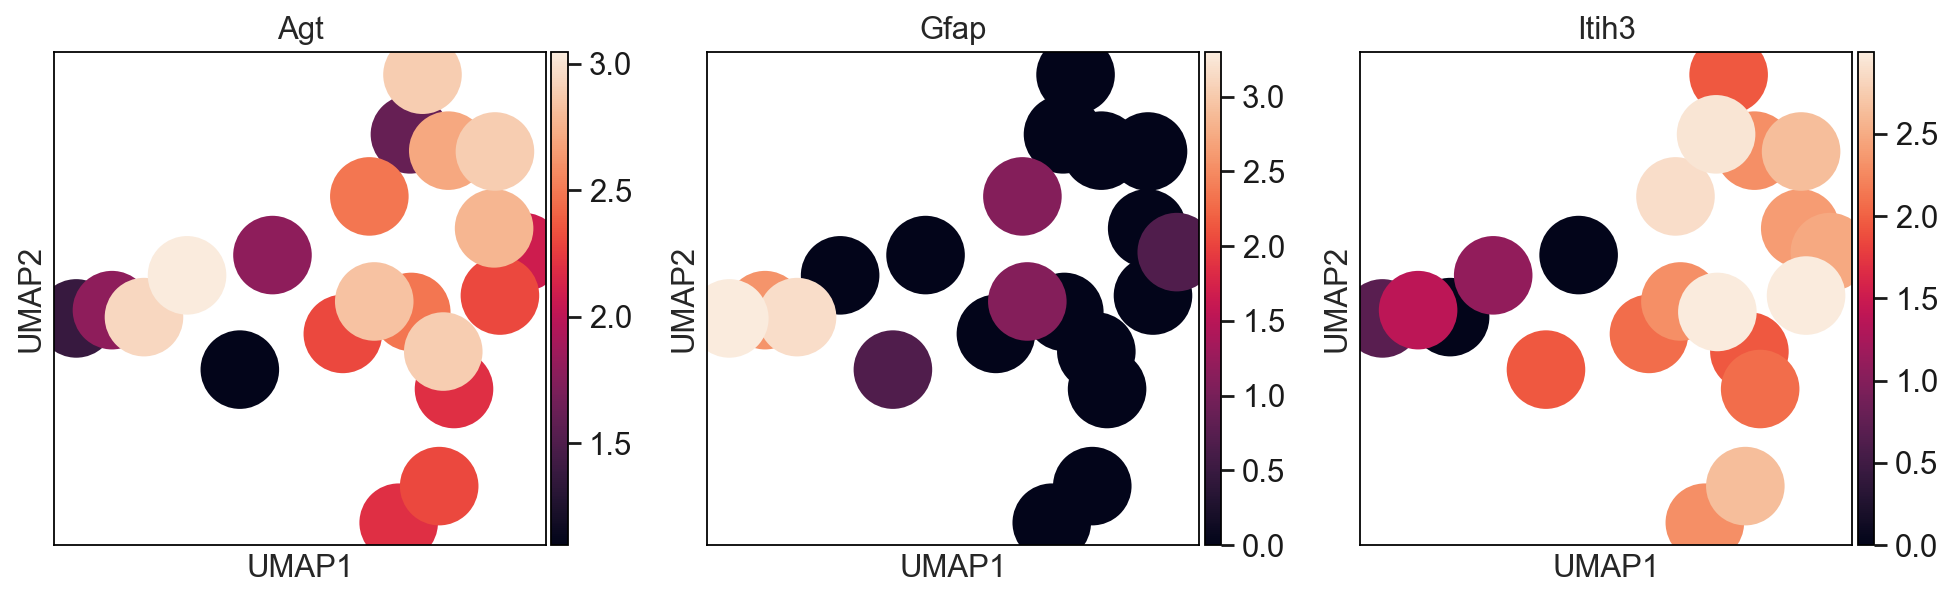

In [170]:
sc.pl.umap(astrocytes, color=genes, size= 5000,
          use_raw=True,save='_astroglial_Fig4e.pdf')

## Figure S4
comparison of cell types to Chen et al

Export the rawdata (norm, log-transformed), hvgenes subsetted data and cell type annotation as csv. Combine them manually

In [171]:
rawdata = pd.DataFrame(adata_down.raw.X,index=adata_down.raw.obs_names, columns=adata_down.raw.var_names)
rawdata

Gnai3  Cdc45  H19  Scml2  Apoh      Narf      Cav2  \
tom_P1_fed_2       0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   
tom_P1_fed_3       0.000000    0.0  0.0    0.0   0.0  1.098612  0.000000   
tom_P1_fed_5       0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   
tom_P1_fed_7       0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   
tom_P1_fed_8       0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   
...                     ...    ...  ...    ...   ...       ...       ...   
tom_P5_fasted_241  0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   
tom_P5_fasted_242  0.000000    0.0  0.0    0.0   0.0  0.000000  0.693147   
tom_P5_fasted_243  0.000000    0.0  0.0    0.0   0.0  0.000000  0.693147   
tom_P5_fasted_244  0.693147    0.0  0.0    0.0   0.0  0.000000  0.000000   
tom_P5_fasted_247  0.000000    0.0  0.0    0.0   0.0  0.000000  0.000000   

                       Klf6     Scmh1     Cox5a  ...  AC123956.1  AC109204.1  \
tom_P1_fed_2       0.000000  0.693147  0.693147  ...         0.0         0.0   
tom_P1_fed_3       0.000000  1.098612  0.693147  ...         0.0         0.0   
tom_P1_fed_5       0.000000  0.000000  0.000000  ...         0.0         0.0   
tom_P1_fed_7       0.000000  0.693147  0.693147  ...         0.0         0.0   
tom_P1_fed_8       0.000000  0.000000  0.693147  ...         0.0         0.0   
...                     ...       ...       ...  ...         ...         ...   
tom_P5_fasted_241  0.000000  0.000000  0.000000  ...         0.0         0.0   
tom_P5_fasted_242  1.386294  0.693147  0.000000  ...         0.0         0.0   
tom_P5_fasted_243  1.098612  0.693147  1.386294  ...         0.0         0.0   
tom_P5_fasted_244  0.000000  0.000000  0.000000  ...         0.0         0.0   
tom_P5_fasted_247  0.000000  0.000000  0.000000  ...         0.0         0.0   

                   AC130529.1  AC154242.1  CT030713.2  AC150035.3  AC164314.2  \
tom_P1_fed_2              0.0         0.0         0.0         0.0         0.0   
tom_P1_fed_3              0.0         0.0         0.0         0.0         0.0   
tom_P1_fed_5              0.0         0.0         0.0         0.0         0.0   
tom_P1_fed_7              0.0         0.0         0.0         0.0         0.0   
tom_P1_fed_8              0.0         0.0         0.0         0.0         0.0   
...                       ...         ...         ...         ...         ...   
tom_P5_fasted_241         0.0         0.0         0.0         0.0         0.0   
tom_P5_fasted_242         0.0         0.0         0.0         0.0         0.0   
tom_P5_fasted_243         0.0         0.0         0.0         0.0         0.0   
tom_P5_fasted_244         0.0         0.0         0.0         0.0         0.0   
tom_P5_fasted_247         0.0         0.0         0.0         0.0         0.0   

                   AC109255.2  AC135964.2  AC110534.5  
tom_P1_fed_2              0.0         0.0         0.0  
tom_P1_fed_3              0.0         0.0         0.0  
tom_P1_fed_5              0.0         0.0         0.0  
tom_P1_fed_7              0.0         0.0         0.0  
tom_P1_fed_8              0.0         0.0         0.0  
...                       ...         ...         ...  
tom_P5_fasted_241         0.0         0.0         0.0  
tom_P5_fasted_242         0.0         0.0         0.0  
tom_P5_fasted_243         0.0         0.0         0.0  
tom_P5_fasted_244         0.0         0.0         0.0  
tom_P5_fasted_247         0.0         0.0         0.0  

[824 rows x 29547 columns]

save the data

In [172]:
rawdata.T.to_csv('./cell_type/tomcells_rawdata_normlog.csv')
rawdata[adata_down.var_names].T.to_csv('./cell_type/tomcells_rawdata_normlog_hvgenes.csv')

save the cell type annotation

In [173]:
cell_types = pd.DataFrame(adata_down.obs['cell_types']).T
cell_types.to_csv('./cell_type/tomcells_cell_types.csv')
cell_types

tom_P1_fed_2      tom_P1_fed_3 tom_P1_fed_5  tom_P1_fed_7  \
cell_types  Pomc_neurons  oligodendrocytes   Astrocytes  Ghrh_neurons   

           tom_P1_fed_8  tom_P1_fed_9   tom_P1_fed_10   tom_P1_fed_11  \
cell_types  Tanycytes_1  Ghrh_neurons  Agrp_neurons_2  Agrp_neurons_2   

             tom_P1_fed_14      tom_P1_fed_15  ... tom_P5_fasted_229  \
cell_types  Agrp_neurons_2  Crhr2_Npw_neurons  ...      Ghrh_neurons   

           tom_P5_fasted_232 tom_P5_fasted_236 tom_P5_fasted_238  \
cell_types    Agrp_neurons_2        Astrocytes         Pitituary   

           tom_P5_fasted_239  tom_P5_fasted_241 tom_P5_fasted_242  \
cell_types         Pitituary  Crhr2_Crh_neurons         Pitituary   

           tom_P5_fasted_243 tom_P5_fasted_244 tom_P5_fasted_247  
cell_types     endothelial_3       Tanycytes_4       Tanycytes_2  

[1 rows x 824 columns]

SciBet online tool is used to compare the Lepr+ cell identity to the published cell types from Chen et al. The reference dataset is provided on the website as one of the default datasets

In [174]:
predicted_cell_type = pd.read_csv('../rawdata/cell_type/Chen/predicted_cell_type.csv',index_col=0)
probability_matrix  = pd.read_csv('../rawdata/cell_type/Chen/probability_matrix.csv',index_col=0)

In [175]:
adata_down.obs['predicted_cell_type'] = predicted_cell_type

In [176]:
probability_matrix = sc.AnnData(probability_matrix)
probability_matrix.obs['cell_types'] = adata_down.obs['cell_types']
probability_matrix

AnnData object with n_obs × n_vars = 824 × 46
    obs: 'cell_types'

In [177]:
probability_matrix.var_names

Index(['Ependy', 'MO', 'Glu7', 'Glu11', 'GABA10', 'GABA6', 'GABA7', 'SCO',
       'Astro', 'Glu10', 'Macro', 'Glu9', 'GABA8', 'Glu12', 'Glu2', 'Glu1',
       'Glu4', 'IMO', 'GABA12', 'GABA14', 'GABA4', 'GABA11', 'Glu13', 'GABA15',
       'Glu6', 'Glu14', 'GABA1', 'Glu3', 'GABA9', 'Glu15', 'Epith2', 'GABA17',
       'Glu5', 'GABA18', 'OPC', 'GABA13', 'Glu8', 'Tany', 'GABA3', 'Micro',
       'Epith1', 'POPC', 'GABA2', 'GABA16', 'GABA5', 'Hista'],
      dtype='object')

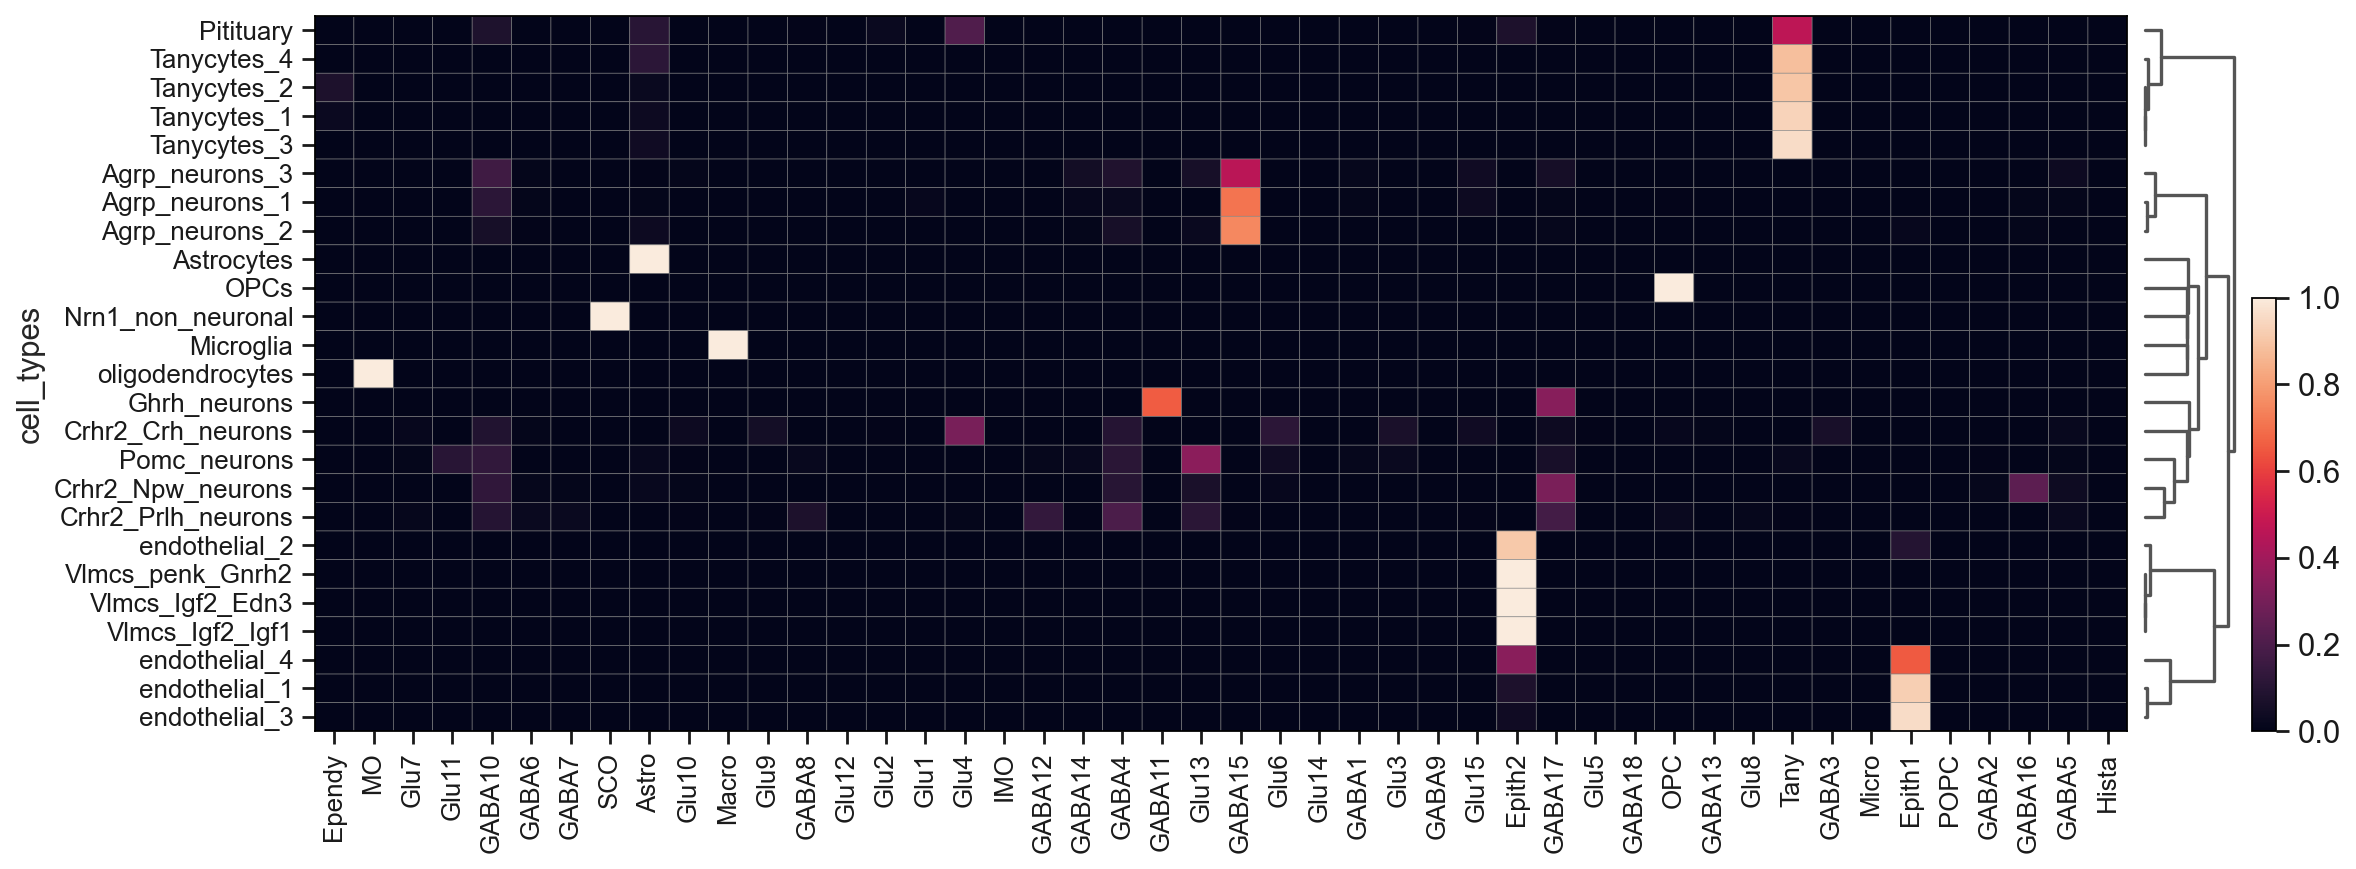

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[14.72, 0.8, 0.2])

In [178]:
sc.pl.matrixplot(probability_matrix, groupby='cell_types',var_names=probability_matrix.var_names,
             dendrogram=True, save='_cell_types_compared_to_Chen_figS4.pdf')

# Figure 5
pyscenic analysis

Load the anndata files with scenic analysis

In [179]:
adata_scenic_down = sc.read('../rawdata/pyscenic/tomcells/tomcells_down_pyscenic.h5ad')

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [180]:
adata_scenic_down

AnnData object with n_obs × n_vars = 824 × 1980
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_down', 'leiden', 'leiden_condition', 'leiden_cluster_numbers', 'cell_types', 'cell_categories', 'cell_types_condition', 'cell_categories_condition', 'Regulon(Atf3)', 'Regulon(Bsx)', 'Regulon(Cebpb)', 'Regulon(Cebpd)', 'Regulon(E2f8)', 'Regulon(Elk3)', 'Regulon(En1)', 'Regulon(Erg)', 'Regulon(Ets1)', 'Regulo

## Fig 5a
cell categories displayed on t-SNE space calculated based on regulon activity

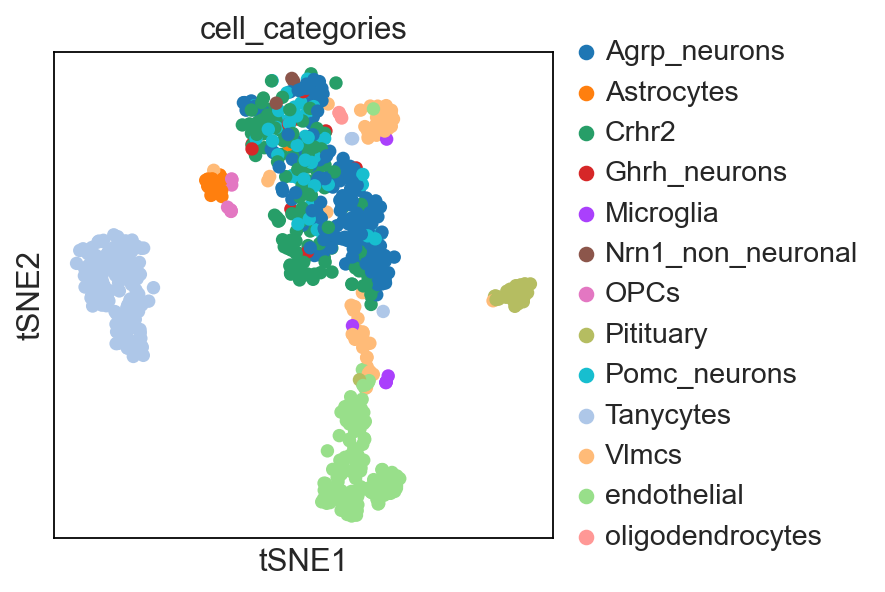

In [181]:
sc.pl.tsne(adata_scenic_down, color=['cell_categories'],save='_cell_categories_Fig5a.pdf')

## Fig 5b
Hieararchical clustering of cell types baed on regulon activity

Load hte data file that contain the information on regulons for tomcells, calculated using log normalised data to maintain as much information as possible

In [182]:
adata_auc_mtx = sc.read('../rawdata/pyscenic/tomcells/tomcells_auc_mtx.h5ad')

In [183]:
adata_auc_mtx

AnnData object with n_obs × n_vars = 824 × 38
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'leiden', 'cell_types', 'cell_categories', 'cell_types_condition', 'cell_categories_condition', 'Regulon(Arnt2)', 'Regulon(Atf3)', 'Regulon(Batf)', 'Regulon(Bclaf1)', 'Regulon(Cebpb)', 'Regulon(Cebpd)', 'Regulon(Dlx1)', 'Regulon(Dlx5)', 'Regulon(E2f8)', 'Regulon(Elf3)', 'Regulon(Elk3)', 'Regulon(Erg)', 'Regulon(Ets1)',

Plot the dendrogram. Note that the differentially active regulons were added using Adobe Illustrator

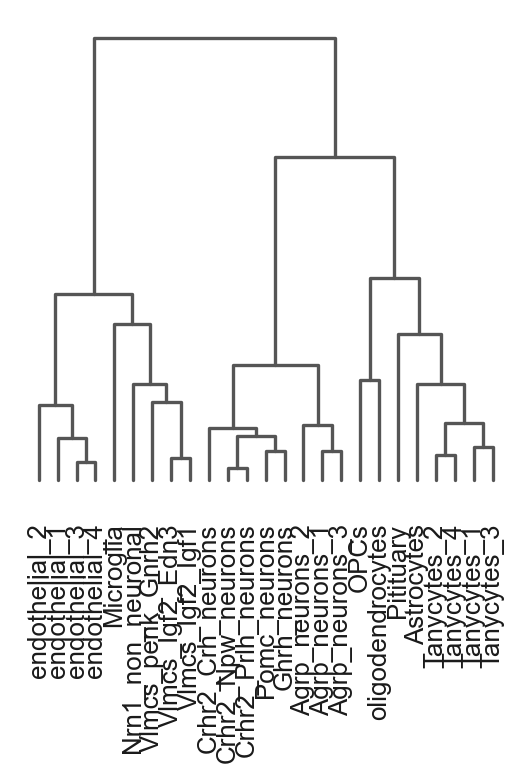

In [184]:
sc.pl.dendrogram(adata_auc_mtx,groupby = 'cell_types',save='_tomcells_auc_mtx_dendrogram_Fig5b.pdf')

For instance, the differences between neural and nonneural clusters are calcualted as follows:

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


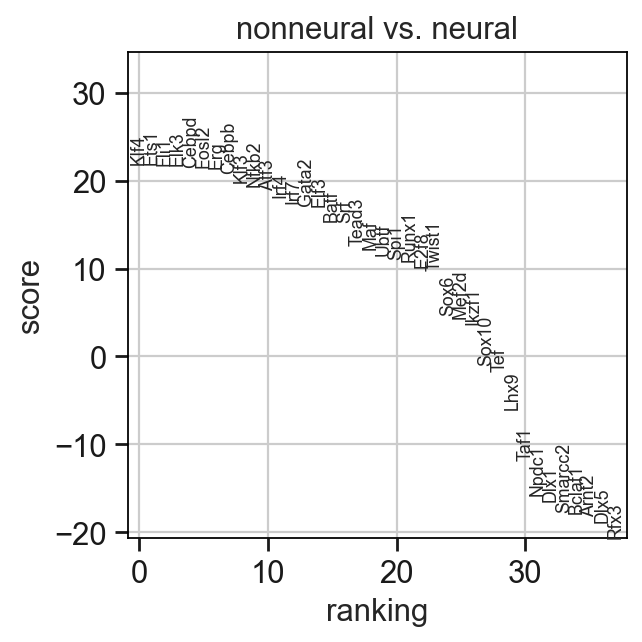

In [185]:
sc.tl.rank_genes_groups(adata_auc_mtx,groupby='level_1',
                        groups=['nonneural'],reference ='neural',method='wilcoxon') #wilcoxon
sc.pl.rank_genes_groups(adata_auc_mtx,groupby='level_1',groups=['nonneural'],n_genes=40)

## Fig S5a
conditions displayed on t-SNE space calculated based on regulon activity

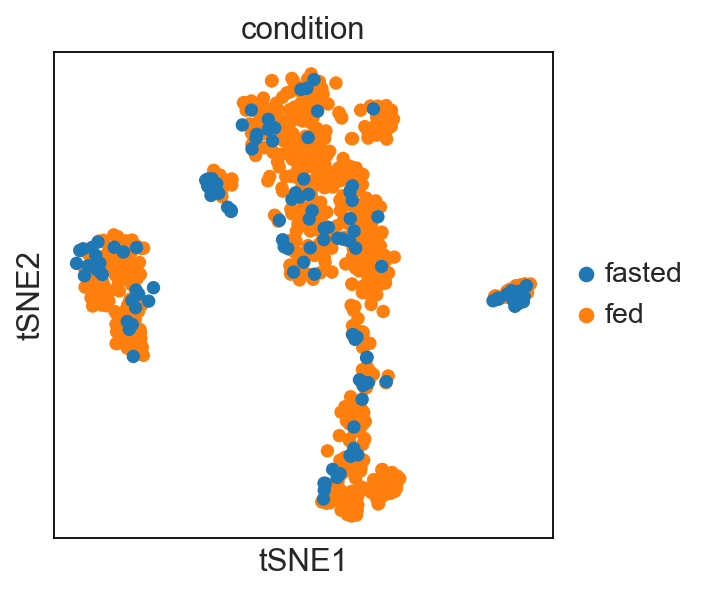

In [186]:
sc.pl.tsne(adata_scenic_down, color=['condition'],save='_condition_FigS5a.pdf')

## Fig S5b
dotplot displaying regulon activity in cell types

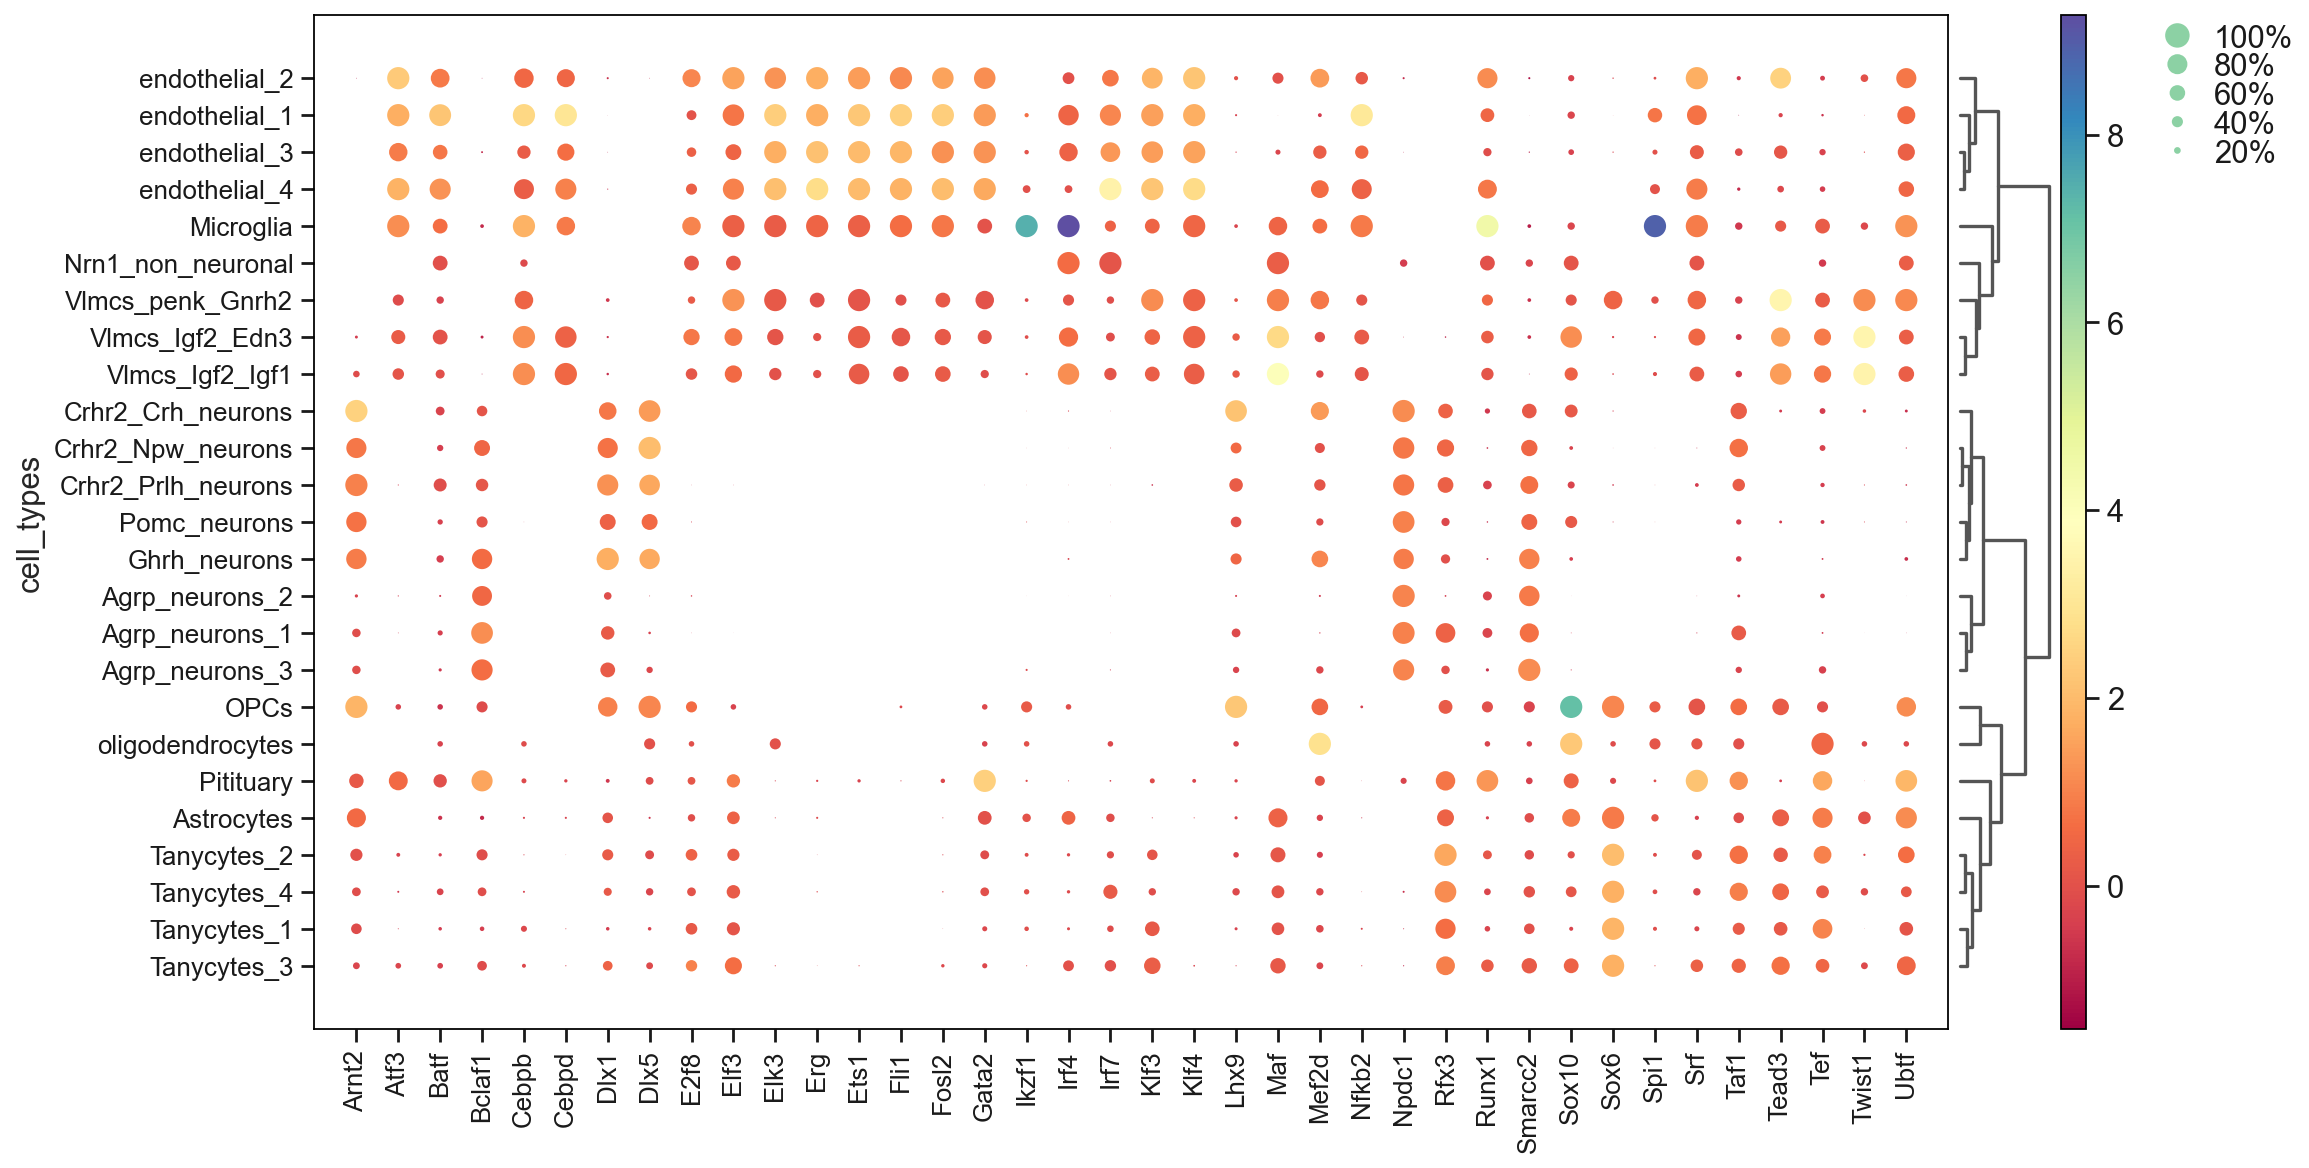

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.299999999999999, 0.8, 0.2, 0.5, 0.25])

In [187]:
sc.pl.dotplot(adata_auc_mtx,var_names=adata_auc_mtx.var_names,groupby='cell_types',
              color_map='Spectral',dendrogram=True, save='_tomdata_regulon_activity_figS5b.pdf')
          

# Figure 6
Comparison of fed and fasted Agrp neurons

Load the Agrp neurons data, that was reanalysed from scratch. The raw data was downsampled to the median number of reads

In [188]:
agrpneurons = sc.read('../rawdata/Lepr_hypothalamus_agrpneurons_down_preprocess.h5ad', 
                      compression='gzip')


/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [189]:
agrpneurons.obs['n_counts'].median()

30923.432

Following downsampling to the median, cell cluster largely together. However, cells from the fasted condition are not equally distributed

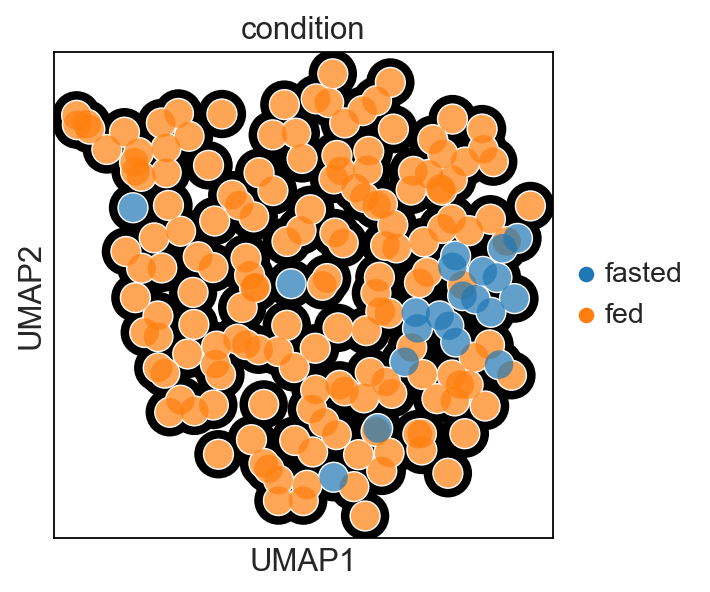

In [190]:
sc.pl.umap(agrpneurons,color = 'condition',add_outline=True,
          save = '_agrpneurons_down_condition_lined.pdf')

First, we will look at the data a bit closer. Some of these stats are used in the paper and/or provided as supplementary tables

Calculate the differentially expressed genes between conditions using wilcoxon rank-sum test

In [191]:
sc.tl.rank_genes_groups(agrpneurons,'condition', method='wilcoxon',n_genes=500)


Generate a table with logfoldchanges, scores and corrected p-calues for top500 differentially expressed genes

In [192]:
result = agrpneurons.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_DGE = pd.DataFrame(
            {group + '_' + key[:1]: result[key][group]
            for group in groups for key in ['names', 'scores','logfoldchanges','pvals_adj']})
result_DGE

fasted_n  fasted_s  fasted_l      fasted_p       fed_n     fed_s  \
0         Chga  7.390724  2.237617  3.204946e-09      Gm8055  5.694098   
1       Gm5963  7.128021  2.370009  1.117348e-08      Tagln3  5.354773   
2          Vgf  7.049210  4.627146  1.316357e-08         Dbp  5.313178   
3       Gm6290  6.887209  3.188280  3.121823e-08       Efnb3  5.162123   
4       Gm6368  6.773371  2.643105  5.522553e-08      Rnf112  5.046096   
..         ...       ...       ...           ...         ...       ...   
495      Tbl1x  3.226874  0.987756  4.785151e-02       Vwa3a  1.792951   
496  Serpina3n  3.226874  0.744861  4.785151e-02       Socs1  1.792951   
497       Atf2  3.224685  0.668704  4.805147e-02      Kif1bp  1.790762   
498       Rgs4  3.224685  1.012676  4.805147e-02  D1Ertd622e  1.788573   
499      Pcgf5  3.222496  1.112441  4.833627e-02       Lin7b  1.788573   

         fed_l     fed_p  
0     1.618013  0.000008  
1     1.110885  0.000035  
2     4.216376  0.000041  
3     1.494021  0.000077  
4     1.337732  0.000127  
..         ...       ...  
495   1.815365  0.616516  
496  28.026730  0.616516  
497   0.329188  0.618171  
498   0.947880  0.618171  
499   0.844128  0.618171  

[500 rows x 8 columns]

Genes upregulated upon fasting with a FDR <0.01

In [193]:
result_DGE[result_DGE['fasted_p'] < 0.01] #263 genes FDR<0.01

fasted_n  fasted_s  fasted_l      fasted_p   fed_n     fed_s     fed_l  \
0       Chga  7.390724  2.237617  3.204946e-09  Gm8055  5.694098  1.618013   
1     Gm5963  7.128021  2.370009  1.117348e-08  Tagln3  5.354773  1.110885   
2        Vgf  7.049210  4.627146  1.316357e-08     Dbp  5.313178  4.216376   
3     Gm6290  6.887209  3.188280  3.121823e-08   Efnb3  5.162123  1.494021   
4     Gm6368  6.773371  2.643105  5.522553e-08  Rnf112  5.046096  1.337732   
..       ...       ...       ...           ...     ...       ...       ...   
258     Map2  3.833282  0.584986  9.439087e-03  Kcnip2  2.217655  1.421169   
259  Zfp354c  3.833282  1.381681  9.439087e-03   Rnpep  2.215466  0.948084   
260   Gabbr2  3.826714  1.007717  9.661540e-03    Gas2  2.213277  2.149609   
261  Gm47283  3.817957  1.625057  9.943493e-03  Ccdc92  2.211087  0.680653   
262   Map7d2  3.815768  0.820016  9.998411e-03  Alkbh7  2.208898  1.069053   

        fed_p  
0    0.000008  
1    0.000035  
2    0.000041  
3    0.000077  
4    0.000127  
..        ...  
258  0.360071  
259  0.361430  
260  0.362572  
261  0.363494  
262  0.364198  

[263 rows x 8 columns]

Genes downregulated upon fasting with a FDR <0.01

In [194]:
result_DGE[result_DGE['fed_p'] < 0.01] #35 genes FDR<0.01

fasted_n  fasted_s  fasted_l      fasted_p    fed_n     fed_s     fed_l  \
0        Chga  7.390724  2.237617  3.204946e-09   Gm8055  5.694098  1.618013   
1      Gm5963  7.128021  2.370009  1.117348e-08   Tagln3  5.354773  1.110885   
2         Vgf  7.049210  4.627146  1.316357e-08      Dbp  5.313178  4.216376   
3      Gm6290  6.887209  3.188280  3.121823e-08    Efnb3  5.162123  1.494021   
4      Gm6368  6.773371  2.643105  5.522553e-08   Rnf112  5.046096  1.337732   
5   Rpl10-ps2  6.628884  3.385633  1.237203e-07    Tppp3  4.980420  1.492186   
6         Ubb  6.585100  1.257736  1.402886e-07     Nsg2  4.892852  1.008487   
7      Gm6433  6.567587  5.197361  1.402886e-07    Nr1d2  4.890663  1.692191   
8       Hspa5  6.523803  1.575215  1.671552e-07      Psd  4.827176  1.372965   
9        Ryr3  6.506289  1.224372  1.690574e-07    Ctxn1  4.811852  0.760718   
10      Sez6l  6.455938  1.957073  2.145834e-07     Per3  4.772446  1.852624   
11      Sox10  6.342100  3.437312  4.145326e-07     Wdr6  4.750555  0.771515   
12       Rpl3  6.204180  1.136484  9.282355e-07    Esyt3  4.746176  1.583674   
13    Gm37421  6.173532  1.116807  1.046891e-06     Nme3  4.649851  1.539508   
14     Gm7198  6.131937  1.738637  1.270228e-06     Pdxp  4.623581  0.982846   
15      Rpl13  6.055315  1.381017  1.922327e-06   Dpysl2  4.617013  0.552295   
16       Lepr  6.029045  3.033251  2.129269e-06    Ddx3y  4.441878  5.906271   
17     Pcdh15  5.989639  2.954845  2.495530e-06     Pltp  4.419986  3.993546   
18       Agrp  5.985260  1.265115  2.495530e-06     Ptms  4.391526  0.699780   
19       Scg2  5.965558  1.170531  2.675334e-06   Amigo2  4.380580  1.064197   
20        Ghr  5.954612  1.420707  2.724455e-06   Dynll2  4.352121  0.618532   
21     Rpl23a  5.945855  2.326588  2.731574e-06  Camk2n1  4.328040  0.851126   
22    N4bp2l1  5.939288  1.798470  2.731574e-06    Pcbd1  4.319283  1.140192   
23       Sv2c  5.895504  2.290403  3.415869e-06  Bhlhe40  4.303958  1.855260   
24     Gm9403  5.875801  2.752187  3.694152e-06    Stmn3  4.236094  0.598412   
25    Gm15500  5.864855  3.652639  3.794514e-06  Ndufb11  4.222958  0.935720   
26     Gm4707  5.768530  1.736082  6.349816e-06    Rph3a  4.218580  1.516052   
27    Rasgrf2  5.766341  1.058383  6.349816e-06    Hsph1  4.021552  0.709454   
28     Acvr1c  5.759774  1.654363  6.374230e-06    Ackr1  4.017174  2.566526   
29      Rpl26  5.735693  1.162983  7.104593e-06   Pnmal1  4.014985  0.803108   
30      Rpl34  5.729125  1.284507  7.146941e-06      Tef  3.890201  1.374713   
31       Dnm3  5.702855  1.035777  8.080444e-06  Gm14539  3.868309  4.336249   
32     Cyp2f2  5.648125  4.411061  1.047050e-05   Fkbp1a  3.848606  0.514235   
33      Hspa8  5.613098  1.100005  1.242624e-05   Sdhaf4  3.842038  1.383370   
34     Gm2033  5.608719  2.460400  1.242624e-05     Lcn2  3.824525  5.780610   

       fed_p  
0   0.000008  
1   0.000035  
2   0.000041  
3   0.000077  
4   0.000127  
5   0.000162  
6   0.000227  
7   0.000227  
8   0.000279  
9   0.000293  
10  0.000344  
11  0.000371  
12  0.000376  
13  0.000548  
14  0.000604  
15  0.000619  
16  0.001255  
17  0.001346  
18  0.001497  
19  0.001556  
20  0.001730  
21  0.001876  
22  0.001919  
23  0.002012  
24  0.002521  
25  0.002607  
26  0.002632  
27  0.005377  
28  0.005431  
29  0.005436  
30  0.007965  
31  0.008560  
32  0.009084  
33  0.009266  
34  0.009715

## Fig 6a

The following are selected from the fasted-enriched genes

In [195]:
#order manually. Keep 'Lepr', 'Agrp', 'Npy' on the top, the rest follows the p-value (FDR)
agrp_fasting_genes=['Lepr', 'Agrp', 'Npy', 'Vgf','Ghr','Acvr1c','Mt1','Trpm3','Asb4', 
                    'Sorcs1', 'Slc8a1','Fkbp5','Sema3a','Slc4a4','Ghsr','Trpv2','Arrb1']

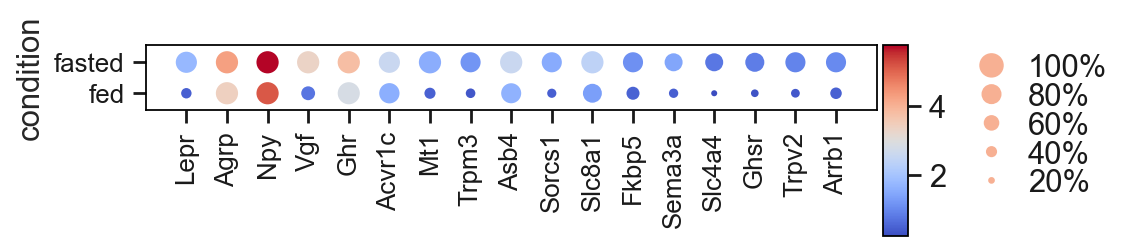

In [196]:
ax = sc.pl.dotplot(
    agrpneurons, agrp_fasting_genes, groupby='condition',
      dendrogram=False, color_map= 'coolwarm', #'Spectral_r',#figsize = [5,2],
        save='_agrp_fasting_genes_Fig6a_coolwarm.pdf')


## Fig 6b

The folowing are the top20 genes enriched in fed cells

In [197]:
fed_genes = result_DGE[result_DGE['fed_p'] < 0.01]['fed_n'][:20]

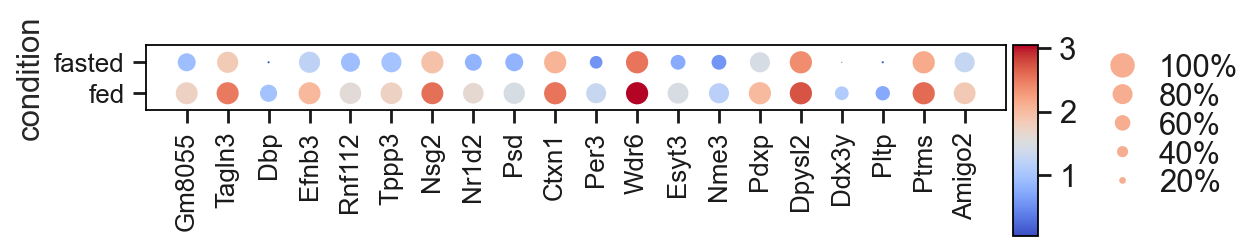

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.0, 0, 0.2, 0.5, 0.25])

In [198]:
sc.pl.dotplot(
    agrpneurons, fed_genes, groupby='condition',
      dendrogram=False, color_map= 'coolwarm', #'Spectral_r',#figsize = [5,2],
        save='_agrp_fed_genes_Fig6b_coolwarm.pdf')

## Fig 6c
Regulon enrichment in cells from fasted versus fed conditions. For agrp neurons, we have recalculated the regulon activity enrichment for single cells using the data from agrp neurons which was downsampled to the median

The regulons detected here are not the same as those detected in the whole dataset. Part of this maybe because only Agrp neurons are analysis. Regulons enriched in every cell is calculated in comparison to other cells, and we may see more active regulons if this dataset is analysed in comparison to all Lepr cells or the whole hypothalamus. Here, we focus on the differences between conditions or subclusters

Load the data

In [199]:
agrpneurons_pyscenic = sc.read('../rawdata/agrpneurons_pyscenic.h5ad')

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [200]:
agrpneurons_pyscenic

AnnData object with n_obs × n_vars = 183 × 3212
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'type', 'plate', 'condition', 'chrY_counts', 'chrX_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'normalisation_factor', 'n_counts_norm', 'n_counts_reg', 'Regulon(Bclaf1)', 'Regulon(Deaf1)', 'Regulon(E2f3)', 'Regulon(E2f6)', 'Regulon(Elf4)', 'Regulon(Elk4)', 'Regulon(Etv5)', 'Regulon(Fos)', 'Regulon(Gata2)', 'Regulon(Jun)', 'Regulon(Jund)', 'Regulon(Kdm5a)', 'Regulon(Rbfox2)', 'Regulon(Six5)', 'Regulon(Smarcc2)', 'Regulon(Sp1)', 'Regul

Load the active regulons as a data frame

In [201]:
auc_mtx_down = pd.read_csv('../rawdata/pyscenic/agrpneurons/agrpneurons_down_to_median.auc.csv', index_col=0)


In [202]:
auc_mtx_down

E2f6      Fosb     Foxn3     Foxo3    Hivep3       Hlf  \
Cell                                                                            
tom_P1_fed_10      0.212999  0.237957  0.105155  0.012555  0.025900  0.000000   
tom_P1_fed_11      0.101492  0.423824  0.167577  0.054719  0.157814  0.021306   
tom_P1_fed_14      0.115973  0.296994  0.267462  0.067984  0.273859  0.035682   
tom_P1_fed_18      0.138664  0.152705  0.104069  0.007323  0.269362  0.034381   
tom_P1_fed_22      0.160350  0.288297  0.271455  0.007659  0.198351  0.067890   
...                     ...       ...       ...       ...       ...       ...   
tom_P5_fasted_180  0.122700  0.361722  0.406384  0.038532  0.485891  0.053340   
tom_P5_fasted_183  0.116034  0.360950  0.224732  0.040743  0.436199  0.024923   
tom_P5_fasted_222  0.122301  0.289074  0.302572  0.048639  0.333696  0.000000   
tom_P5_fasted_223  0.145511  0.453139  0.267194  0.039953  0.292742  0.000000   
tom_P5_fasted_232  0.169230  0.318288  0.118048  0.048560  0.228040  0.024892   

                        Jun     Npdc1      Rfx3     Thoc2  
Cell                                                       
tom_P1_fed_10      0.180392  0.317579  0.057105  0.078484  
tom_P1_fed_11      0.437107  0.308211  0.313342  0.086782  
tom_P1_fed_14      0.322871  0.304582  0.312982  0.064536  
tom_P1_fed_18      0.163895  0.347789  0.190039  0.178155  
tom_P1_fed_22      0.252542  0.306718  0.278206  0.059536  
...                     ...       ...       ...       ...  
tom_P5_fasted_180  0.378451  0.314139  0.517512  0.286799  
tom_P5_fasted_183  0.325668  0.274773  0.492352  0.332175  
tom_P5_fasted_222  0.377992  0.298403  0.455069  0.213659  
tom_P5_fasted_223  0.506147  0.276704  0.370871  0.257981  
tom_P5_fasted_232  0.240615  0.324293  0.363645  0.171442  

[183 rows x 10 columns]

convert into anndata

In [203]:
adata_auc_mtx_down = sc.AnnData(auc_mtx_down)
adata_auc_mtx_down.obs['condition'] = adata_down.obs['condition']

In [204]:
adata_auc_mtx_down

AnnData object with n_obs × n_vars = 183 × 10
    obs: 'condition'

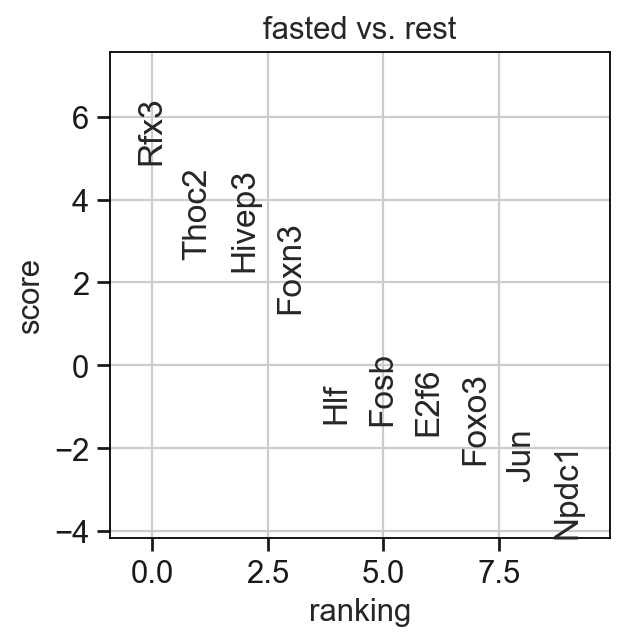

In [205]:
sc.tl.rank_genes_groups(adata_auc_mtx_down,groupby = 'condition',method='wilcoxon')
sc.pl.rank_genes_groups(adata_auc_mtx_down,groups = ['fasted'],fontsize = 15,
                    save='_fasted_fed_regulons_wilcoxon_Fig6c.pdf')

## Figure S6a
Gene regulatory network aanalysis of Agrp neurons

In [206]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyscenic.rss import regulon_specificity_scores


###### Generate scaled dataframe for regulon activity

In [207]:
auc_mtx_Z_down = pd.DataFrame( index=auc_mtx_down.index )
for col in list(auc_mtx_down.columns):
    auc_mtx_Z_down[ col ] = ( auc_mtx_down[col] - auc_mtx_down[col].mean()) / auc_mtx_down[col].std(ddof=0)

###### Generate a heatmap

In [208]:
# From the pyscenic analysis pipeline
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [209]:
cats = sorted(list(set(adata_down.obs['condition'])))

In [210]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata_down.obs['condition'] ] #cellAnnot['Celltype_Garnett']

Generate a color map

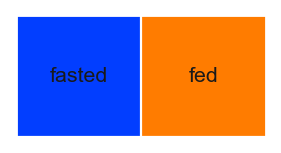

In [211]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Calculate regulon specificity scores based on condition

In [212]:
rss_condition_down = regulon_specificity_scores( auc_mtx_down, agrpneurons.obs['condition'] )
rss_condition_down

E2f6      Fosb     Foxn3     Foxo3    Hivep3       Hlf       Jun  \
fed     0.79094  0.768186  0.750097  0.710726  0.758919  0.582338  0.777026   
fasted  0.28004  0.274203  0.290761  0.261816  0.297300  0.243676  0.265480   

           Npdc1      Rfx3     Thoc2  
fed     0.802369  0.724165  0.722254  
fasted  0.277602  0.318848  0.304492

Calculate the rop regulated regulons using the regulon specificity scores

In [213]:
topreg_down = []
for i,c in enumerate(cats):
    topreg_down.extend(
        list(rss_condition_down.T[c].sort_values(ascending=False)[:5].index)
    )
topreg_down = list(set(topreg_down))

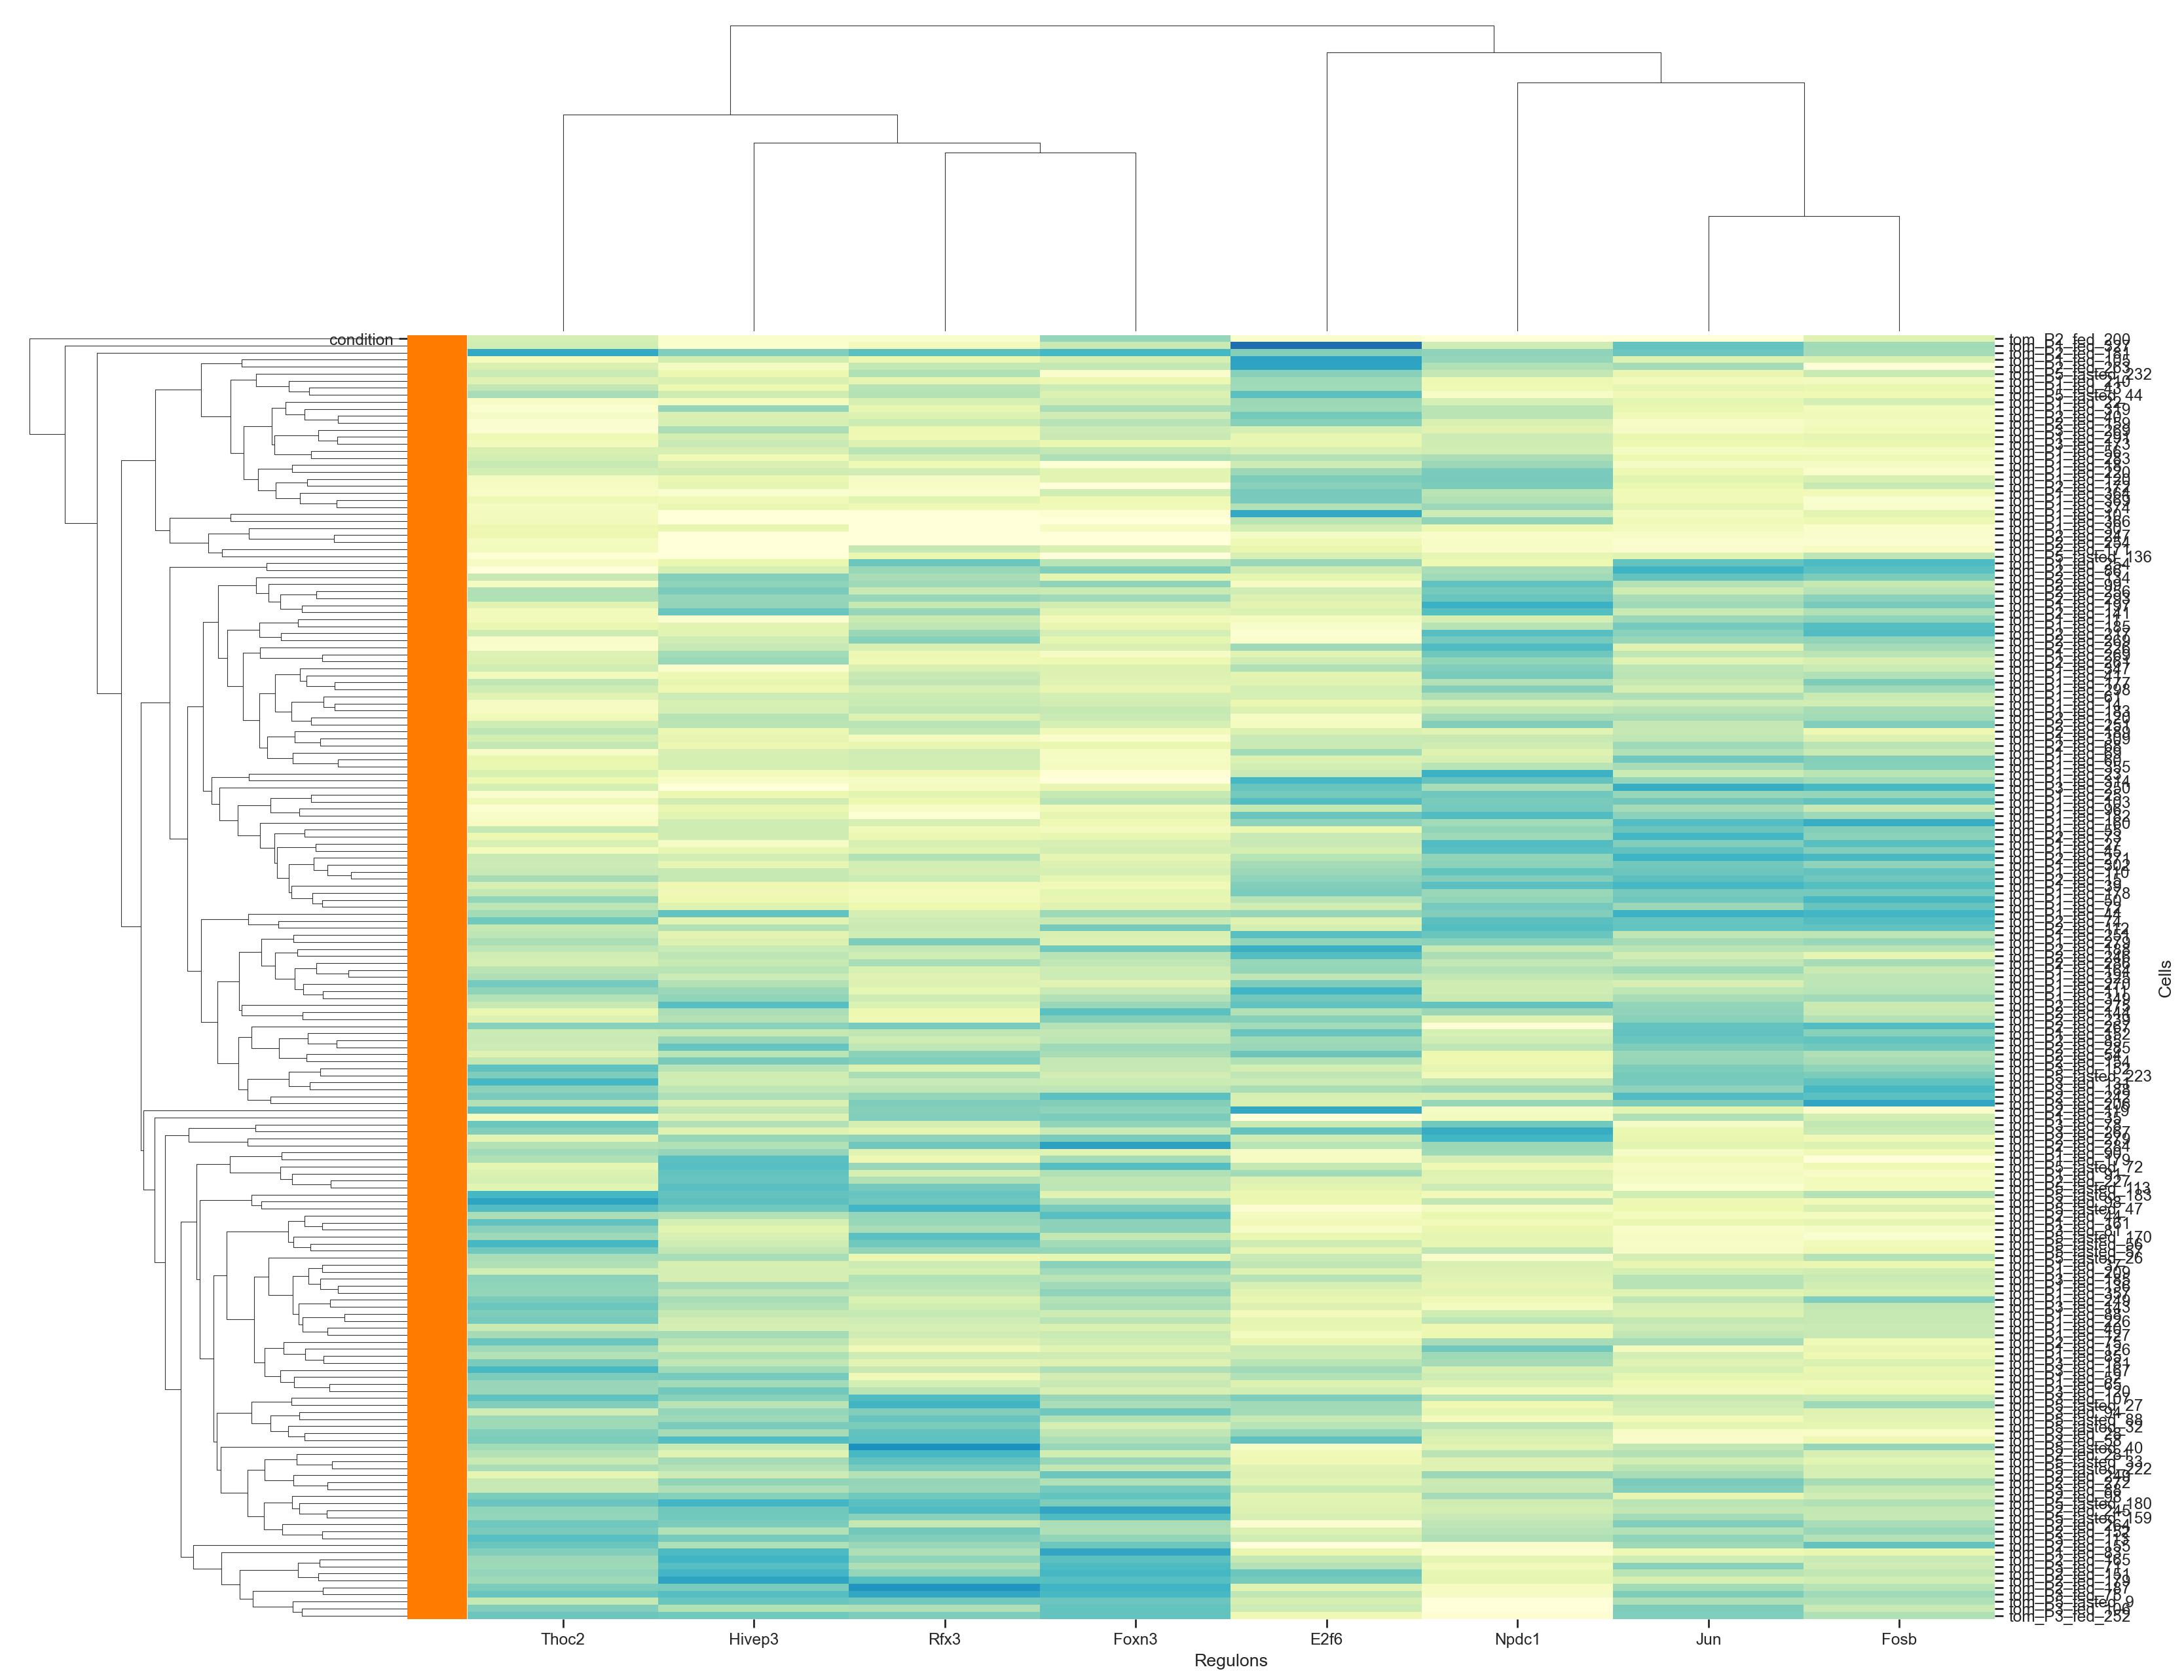

In [214]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(auc_mtx_Z_down[topreg_down],  square=False,  linecolor='gray',
    yticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16))
g.ax_heatmap.set_ylabel('Cells')    
g.ax_heatmap.set_xlabel('Regulons')
g.ax_row_colors.set_yticks([0.5])
g.ax_row_colors.set_yticklabels(['condition'])
g.cax.set_visible(False)
g.savefig("./figures/heatmap_regulons_agrpneurons_down_topreg_rowclust_figS6a.pdf")

## Fig. S6b

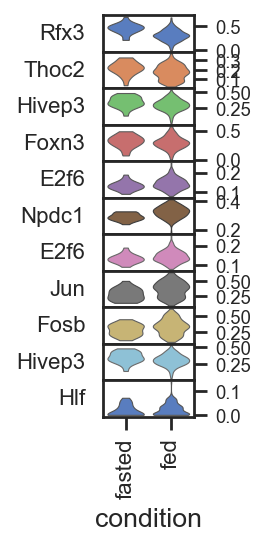

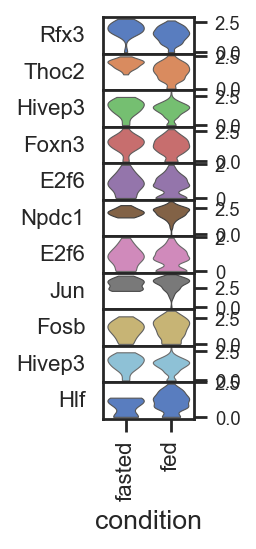

In [215]:
sc.pl.stacked_violin(adata_auc_mtx_down,var_names=['Rfx3','Thoc2','Hivep3','Foxn3','E2f6',
                             'Npdc1','E2f6','Jun','Fosb','Hivep3','Hlf'],groupby='condition',use_raw=False,swap_axes=True,
                    save='_fasted_fed_regulons_fig6b_left.pdf')
sc.pl.stacked_violin(agrpneurons,var_names=['Rfx3','Thoc2','Hivep3','Foxn3','E2f6',
                             'Npdc1','E2f6','Jun','Fosb','Hivep3','Hlf'],groupby='condition',swap_axes=True,
                    save='_fasted_fed_TFs_expression_fig6b_right.pdf')


# Figure 7

CELLECT analyis on BMI GWAS, to be contributed by the Pers group

# Tables

In [216]:
result = agrpneurons.uns['rank_genes_groups']
groups = result['names'].dtype.names
cluster = agrpneurons
test = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','logfoldchanges','pvals_adj']})
gene_ids = cluster.raw.var.index.values
#recalculate the averages and pct
obs = cluster.raw[:,gene_ids].X
obs = pd.DataFrame(obs,columns=gene_ids,index=cluster.obs['condition'])
average_obs = obs.groupby(level=0).mean()
obs_bool = obs.astype(bool)
fraction_obs = obs_bool.groupby(level=0).sum()/obs_bool.groupby(level=0).count()
df0 = pd.concat([average_obs.T.add_suffix("_mean"), fraction_obs.T.add_suffix("_pct")], 
              axis=1).sort_index(axis=1,ascending=True)
df1 = df0.loc[test.iloc[:,0]] #enriched in fasted
df2 = df0.loc[test.iloc[:,4]] #enriched in fed


Get the data and names of the differentially expressed genes in fasted cells

In [217]:
diff_fasted = test[test['fasted_l'] >1.5][test['fasted_p'] < 0.01][test.columns[0:3]]
#diff_fasted = test[test['fasted_l'] >1.5][test['fasted_p'] < 0.01]
diff_fasted.index = range(93)
diff_fasted

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


fasted_n  fasted_s  fasted_l
0      Chga  7.390724  2.237617
1    Gm5963  7.128021  2.370009
2       Vgf  7.049210  4.627146
3    Gm6290  6.887209  3.188280
4    Gm6368  6.773371  2.643105
..      ...       ...       ...
88    Rps29  3.892390  1.592728
89      Trf  3.877065  1.850161
90    Vwa5a  3.863930  1.993978
91    Arrb1  3.844227  1.532537
92  Gm47283  3.817957  1.625057

[93 rows x 3 columns]

Get the data and names of the differentially expressed genes in fed cells

In [218]:
diff_fed = test[test['fed_l'] >1.5][test['fed_p'] < 0.01][test.columns[4:7]]
#diff_fasted = test[test['fasted_l'] >1.5][test['fasted_p'] < 0.01]
diff_fed.index = range(13)
diff_fed

/Users/onurbasak/miniconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


fed_n     fed_s     fed_l
0    Gm8055  5.694098  1.618013
1       Dbp  5.313178  4.216376
2     Nr1d2  4.890663  1.692191
3      Per3  4.772446  1.852624
4     Esyt3  4.746176  1.583674
5      Nme3  4.649851  1.539508
6     Ddx3y  4.441878  5.906271
7      Pltp  4.419986  3.993546
8   Bhlhe40  4.303958  1.855260
9     Rph3a  4.218580  1.516052
10    Ackr1  4.017174  2.566526
11  Gm14539  3.868309  4.336249
12     Lcn2  3.824525  5.780610